# TempEst-NEXT Validation Suite

This Notebook provides a standard suite of model tests for TempEst-NEXT.  This serves two purposes:

1. Reproducibility of research.  This notebook is used to generate final manuscript figures relating to model performance. The notebook itself is provided with the published model and dataset, allowing exact reproducibility (and easy modification) of the analysis.
2. Efficient, consistent testing.  After modifying the model, running this notebook is a quick way to make sure everything still works and to assess performance impacts.

For validation, we use two pre-retrieved datasets as well as some automatic retrieval of new data.  The two pre-retrieved datasets are a "development" set of ~900 USGS gages (nominally 1,000; 900ish with overlapping data coverage) and a "test" set of 331 (nominal 400) USGS gages paired with daymet meteorology, 3DEP topography, NLCD land cover, etc.  The development set was used for model development and tuning, while the test set is reserved for final validation (i.e., here).  Test-set validations have been run during the development process, but are never used to directly inform model design.

The test suite also illustrates model runtime.

Some cells were used for initial data preparation, but do not need to be rerun.  These have been set to "raw" rather than Python, so simply running the entire Notebook will run all tests but nothing extraneous.

## Dependencies

To run the entire Notebook, requirements are:

- Python dependencies: TempEst-NEXT, matplotlib, and seaborn.  TempEst-NEXT is available (under that name) on the Python Package Index, so `pip install TempEst-NEXT`.  This will also install, as a dependency, TempEst-NEWT, the calibrated version of the model.
- A directory (specify location in `bp=` in the first cell) containing `DevData.csv`, `TestData.csv`, `DevDataHRRR3.csv`, and `TestDataHRRR3.csv`.  These should be provided with the notebook.  It should also contain a `results` subdirectory.
- In the same directory as the notebook:
    - An `ecoregions` directory, containing `NA_CEC_Eco_Level1.shp` (EPA Level I Ecoregions).
    - A `val_figures` directory

The preprocessing chunks have additional requirements, but are only used to generate the above data files and so don't need to be run.  They are set to `raw`, not `code`, so if the entire notebook is run they will not be executed.

Running the Notebook will reproduce all manuscript performance data and figures, except those relating to "true" forecasting (as opposed to reforecasting).  This is because performance evaluation for "true" forecasting requires separate steps to be run days apart and therefore can't be fully automated in a single run, though simply generating the forecast is automatic.

## Assessed Model Characteristics

The goal is to assess several model performance characteristics.  Forecasting is used for a handful of tests, but most analysis focuses on hindcasting for computational convenience.  It is assumed that any performance discrepancies in forecasting vs hindcasting would be apparent in the tests that cover both, and thus that not every analysis needs to test forecasting.

In this notebook, forecasting is primarily tested by using archived weather forecasts to predict what the forecast would have been for time periods where observations are available, which is necessary for automatic testing.  There is code to run a "real" forecast, but this cannot be automatically evaluated because observations are not available, so the user is left to go back and check once observations are available.

1. Calibrated model hindcasting and forecasting performance, using TempEst-NEWT like a typical single-watershed model
2. General ungaged hindcasting and forecasting performance
3. Ungaged-region hindcasting performance
4. Ungaged-elevation hindcasting performance
5. Ungaged-time-period hindcasting performance
6. Disturbance hindcasting performance?  TBD
7. Small-stream hindcasting performance?  TBD

## Tests

The following tests are used to assess the above performance characteristics.  Forecast tests cover just 2022, since HRRR retrieval is slow.

- Calibrated testing: train a model on the first 70% of observations for each stream, then evaluate performance for predicting the last 30%.  This uses the full dataset.
  - Use meteorology estimates (daymet) for training and testing: hindcast test.  Because the model architecture does not actually use "today's" weather (up through yesterday only), this is also a 24-hour forecast test.
  - Use weather forecast archives (HRRR, GFS/GEFS) for training and testing: forecast test.  Test forecast period of 2 days.
- Gagewise cross-validation: partition development dataset gages into *k* equal sets.  Train a model on all partitions but one, and evaluate performance for predicting the excluded partition.  This tests general ungaged performance, not accounting for any potential impact of having used the same dataset for model tuning.  Hindcasting (met estimate) only.  This uses the development dataset to show whether model tuning introduced any performance discrepancies (compared to test set validation).
- Test set validation: train a model on the development set, and evaluate performance for predicting the test set.  This tests general ungaged performance for a fully-independent dataset.
  - Meteorology estimates (hindcast)
  - Weather forecast archives (forecast) for 2-day (tomorrow) forecasts.  This has to be done with HRRR, since GFS doesn't have as readily-available long-term archives.
    - Trained on estimates/test on forecasts (forecast with heterogeneous data).
    - Trained on forecasts (homogeneous).
- Extrapolation hindcasting tests: partition the combined development and testing sets along some characteristic of interest, and use a model trained on one group to predict the other group.  This tests the ability of TempEst-NEXT to extrapolate in terms of specific characteristics.  All hindcasting.
  - Regional: partition the CONUS into contiguous regions and run leave-one-out cross-validation over the regions.
  - Elevation: train a model on the lower elevations and predict higher elevations.  Partial dependency plots and previous research suggest there is a major shift in watershed dynamics around 2300 m, and it is difficult to extrapolate past that barrier.
  - Time (walk-forward validation): train a model up to a given year, then predict the next year.  This tests whether the model can extrapolate forward in time.
- Regime-shift hindcasting: identify a set of watersheds for which the observed thermal regime has shifted significantly.  Train the model on everything else, then try to predict the disturbed watersheds and see how the model performs.  This assesses whether TempEst-NEXT is capable of capturing regime shifts.
- Small-stream hindcasting: if possible, use the model to predict temperatures at very small (e.g., first-order headwaters, centimeters to a few meters wide) streams where some observations are available, just to see if it works there.
- True forecasting: run TempEst-NEXT with a 1-16 day lead time in real time (HRRR and GFS), then come back and check the performance.  This needs to be rerun many times, preferably over multiple seasons, to be meaningful.


A full run takes about 3 hours.

# Data Preparation

In [1]:
import NEXT
from NEXT import wforecast
import NEWT
from rtseason import ThreeSine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import os
import dataretrieval.nwis as nwis
import geopandas as gpd
import matplotlib.animation as anim
import shapely
import scipy
from sklearn.ensemble import RandomForestClassifier
from scores.probability import brier_score_for_ensemble
import xarray as xr
from math import floor, ceil
warnings.catch_warnings(action="ignore")
sns.set_context("paper")
bp = "/scratch/dphilippus/notebooks/next_validation/"

ERROR 1: PROJ: proj_create_from_database: Open of /u/wy/ch/dphilippus/.conda/envs/next/share/proj failed


Use the `variant` options below to indicate the use of a different model implementation, so that all validations are rerun and results saved separately.  `coef_variant` refers to coefficient estimation and `newt_variant` to NEWT model design.

In [2]:
coef_variant = "_reference"  # Currently: constant dates, 5-PC
newt_variant = "_reference"
rerun = False

There are some major outliers that are either erroneous (negative temperatures) or wildly unrepresentative (hot springs) that we remove to produce realistic performance estimates.

In [3]:
datafiles = [bp + x + ".csv" for x in ["DevDataBuffers", "TestDataBuffers", "DevDataHRRR3", "TestDataHRRR3"]]

In [4]:
dev_data = pd.read_csv(bp + "DevDataBuffers.csv", dtype={"id": "str"}, parse_dates=["date"]).drop(columns=["swe", "tmin"]).dropna()
dev_data = dev_data[(dev_data["temperature"] > -0.5) & (dev_data["temperature"] < 40)]
test_data = pd.read_csv(bp + "TestDataBuffers.csv", dtype={"id": "str"}, parse_dates=["date"]).dropna()
test_data["day"] = test_data["date"].dt.day_of_year
all_data = pd.concat([dev_data, test_data]).drop(columns=["asp_north", "asp_east", "id_type", "unknown", "elev_std", "frozen", "cold_prcp"])
test_data_hrrr = pd.read_csv(bp + "TestDataHRRR3.csv", dtype={"id": "str"}, parse_dates=["date"]).merge(test_data[["id", "date", "canopy", "flowdir"]], on=["id", "date"], how="left")
dev_data_hrrr = pd.read_csv(bp + "DevDataHRRR3.csv", dtype={"id": "str"}, parse_dates=["date"]).merge(dev_data[["id", "date", "canopy", "flowdir"]], on=["id", "date"], how="left")
all_data_hrrr = pd.concat([test_data_hrrr, dev_data_hrrr]).drop(columns=["elev_std", "asp_north", "asp_east"])

### Forecast Archive Retrieval (does not need to be run)

A one-month run takes 0.02 hours, so 72 months should be about 1.5 hours, for a total of ~500 core-hours for the test set.  Needs to be run distributed.

### Data Preprocessing (does not need to be run)

# Calibrated Tests

Full dataset.

In [5]:
def cut_dev(gid, data, start=None):
    idd = data[data["id"] == gid]
    if idd["temperature"].mean() > 35 or idd["temperature"].mean() < 0:
        return (None, None)  # bad data or major outlier
    if start is None:
        cut = round(len(idd) * 0.7)
        if cut >= 365:
            return (idd.iloc[cut:], idd["date"].iloc[cut+1])
        else:
            return (None, None)  # dataset too small
    else:
        return idd[idd["date"] >= start]

def cal_val(gid, data, test_data = None, cal_fn = cut_dev, val_fn = cut_dev):
    (train, cutoff) = cal_fn(gid, data)
    if test_data is None:
        test_data = data
    # try:
    if cutoff is not None:
        test = cal_fn(gid, data, cutoff)
        model = NEWT.Watershed.from_data(train)
        if model is not None:
            return model.run_series(test)
    # except Exception as e:
    #     warnings.warn(str(e))

## Hindcast

In my last test, 919 watersheds took 26 minutes to train and predict, for about 2 seconds per watershed.

With GAM-sensitivity, 1225 watersheds took 42 minutes to train and predict, still at ~2 seconds each.

With full-series runs and GAM-sensitivity, 1225 watersheds took 10 minutes to train and predict, for ~0.5 seconds each.

In [6]:
file = bp + f"results/calibrated_hindcast{newt_variant}.csv"
if not rerun and os.path.exists(file):
    preds = pd.read_csv(file, dtype={"id": "str"}, parse_dates=["date"])
else:
    start = time.time()
    # with warnings.catch_warnings(action="ignore"):
    preds = pd.concat([cal_val(x, all_data) for x in all_data["id"].unique()])
    runtime = (time.time() - start) / 60
    count = len(preds["id"].unique())
    print(f"Trained and ran {count} watershed models in {runtime:.1f} minutes.")
    preds.to_csv(file, index=False)

Overall performance summary below.  Note that stationarity, in particular, does absurdly well as a comparison point (same temperature today as yesterday).  As far as I'm aware, this comparison has not been run for most previous models.  It would be interesting to see how much of a lag is required for NEWT to outperform stationarity.  This does suggest that, if you have observations, "same as yesterday" is probably a better bet than most non-data-assimilating models.

Interestingly, when a massive outlier that was predicting anomalies in the thousands of degrees is removed, global performance is very similar to gagewise performance.  Note that huge anomaly sensitivity isn't representative of any real use case, since in a calibrated model that would be corrected for and the (smoothed) coefficient estimation model won't predict such high sensitivity.  (If it did happen, it would be fairly obvious that ~3000 C is not a reasonable estimate.)

Using GAM-anomaly reduced median and global RMSE by about 0.1 C to 1.4 C (for both).  Anomaly NSE increased to 0.61 (0.92 globally), median R2 to 0.95, and global R2 to 0.97.  Overall NSE increased to 0.95 and 0.97.

In [7]:
with warnings.catch_warnings(action="ignore"):
    print(preds.groupby("id").apply(NEWT.analysis.perf_summary).describe())

                R2         RMSE          NSE  StationaryNSE  ClimatologyNSE  \
count  1225.000000  1225.000000  1225.000000    1225.000000     1225.000000   
mean      0.937241     1.399566     0.937215       0.977105        0.952473   
std       0.067866     0.418336     0.067968       0.017552        0.048964   
min       0.373559     0.105841     0.368970       0.816626        0.287647   
25%       0.933140     1.159317     0.933120       0.969819        0.937219   
50%       0.952737     1.385609     0.952736       0.980610        0.959158   
75%       0.967702     1.606944     0.967699       0.989068        0.978736   
max       0.992155     6.878842     0.992146       0.999378        1.000000   

        AnomalyNSE        Pbias         Bias      MaxMiss  
count  1089.000000  1225.000000  1225.000000  1225.000000  
mean      0.557052     0.016654     0.001475     1.231975  
std       0.199222     0.099346     0.007731     0.756906  
min      -0.346025    -0.276735    -0.034257    

In [8]:
NEWT.analysis.perf_summary(preds)

,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
0,0.967017,1.417574,0.967016,0.984059,0.604775,0.921333,0.006467,0.000864,1.457304


## Forecast

Trained and tested with HRRR.  Note this limits the data coverage (~2018-22).  Since the POR is shorter and there are fewer applicable watersheds, this takes 4 minutes.

Performance here is very similar, though a little worse; at calibrated sites, the seasonal skill dominates and the slight penalty to anomaly performance has little effect.  Median/global R2 0.95/0.96, RMSE 1.4/1.5 C, NSE 0.95/0.96, pbias 0.007%/0.01%, max-miss 1.3/1.1 C.

In [9]:
file = bp + f"results/calibrated_reforecast{newt_variant}.csv"
if not rerun and os.path.exists(file):
    preds = pd.read_csv(file, dtype={"id": "str"}, parse_dates=["date"])
else:
    start = time.time()
    # with warnings.catch_warnings(action="ignore"):
    preds = pd.concat([cal_val(x, all_data_hrrr) for x in all_data_hrrr["id"].unique()])
    runtime = (time.time() - start) / 60
    count = len(preds["id"].unique())
    print(f"Trained and ran {count} watershed models in {runtime:.1f} minutes.")
    preds.to_csv(file, index=False)

/tmp/ipykernel_326996/2953505268.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  preds = pd.read_csv(file, dtype={"id": "str"}, parse_dates=["date"])


In [10]:
with warnings.catch_warnings(action="ignore"):
    print(preds.groupby("id").apply(NEWT.analysis.perf_summary).describe())

                R2         RMSE          NSE  StationaryNSE  ClimatologyNSE  \
count  1027.000000  1027.000000  1027.000000    1027.000000     1027.000000   
mean      0.934991     1.449692     0.934942       0.977017        0.977886   
std       0.049302     0.443301     0.049459       0.018236        0.020507   
min       0.475008     0.111066     0.474925       0.824091        0.781970   
25%       0.920180     1.122598     0.920176       0.969221        0.968671   
50%       0.945416     1.431002     0.945409       0.980629        0.981338   
75%       0.964443     1.801454     0.964428       0.989583        0.991856   
max       0.992155     2.779918     0.992146       0.999835        1.000000   

       AnomalyNSE        Pbias         Bias      MaxMiss  
count  866.000000  1027.000000  1027.000000  1027.000000  
mean     0.515598     0.025191     0.002232     1.368869  
std      1.056598     0.127464     0.009032     0.700930  
min    -29.953391    -0.231682    -0.025038     0.03

In [11]:
NEWT.analysis.perf_summary(preds)

,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
0,0.961891,1.527219,0.961889,0.98268,0.615097,0.912682,0.010196,0.001326,1.148731


# Test Set Validation

In [8]:
start = time.time()
with warnings.catch_warnings(action="ignore"):
    model = NEXT.NEXT.from_data(dev_data)
runtime = int(time.time() - start)
print(f"Took {runtime} seconds to train")

Took 142 seconds to train


In [ ]:
model.to_pickle("coefs.pickle")

## Hindcast

This (full timeseries for 750k rows/331 watersheds) took 22 minutes, 1300 seconds.  As before, that's about 1.5 years per second.  The next run took 1200 seconds.

With single-pass and GAM-sensitivity, it took 24 seconds, or 86 years per second.

In [14]:
def predict(ws):
    print("|", end="")
    try:
        return model.run(ws, reset=True)
    except:
        return None

In [15]:
ppath = bp + f"results/TestSet_hindcast{coef_variant}.csv"
if not rerun and os.path.exists(ppath):
    preds = pd.read_csv(ppath, dtype={"id": "str"}, parse_dates=["date"])
else:
    start = time.time()
    with warnings.catch_warnings(action="ignore"):
        preds = test_data.groupby("id").apply(predict, include_groups=False).reset_index().drop(columns="level_1")
    runtime = int(time.time() - start)
    print(f"Took {runtime} seconds to predict")
    # preds.to_csv(ppath, index=False)

In [16]:
with warnings.catch_warnings(action="ignore"):
    perf = preds.groupby(["id", "lat", "lon"]).apply(NEWT.analysis.perf_summary, include_groups=False).reset_index()
perf.describe()

,lat,lon,level_3,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,320.000000,320.000000,320.0,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000
mean,39.902969,-95.030326,0.0,0.885257,2.351657,0.132774,0.978241,0.913688,0.264403,1.780932,0.115049,2.380813
std,4.643460,17.260681,0.0,0.139703,0.979340,6.758398,0.019003,0.076455,1.022662,12.678522,1.160956,1.783340
min,28.332787,-124.357089,0.0,0.043903,1.191192,-109.672987,0.824755,0.339466,-10.598032,-38.357194,-3.867501,0.172191
25%,36.555978,-111.425710,0.0,0.874700,1.787417,0.802699,0.972066,0.898901,0.193964,-3.913541,-0.498748,1.070439
50%,40.175895,-87.479876,0.0,0.929003,2.128395,0.891917,0.981524,0.931081,0.533493,0.877234,0.108105,1.913475
75%,43.327292,-81.167361,0.0,0.954358,2.584383,0.928943,0.990598,0.949809,0.666485,5.320108,0.651611,3.280726
max,48.984601,-67.935278,0.0,0.982290,8.135228,0.979604,0.999155,0.996135,0.833758,125.246483,5.702966,11.135823


In [ ]:
NEWT.analysis.perf_summary(preds)

### Predictability Analysis

Analyze spatiotemporal predictability in cross-validation.

#### Daily Spatial and Spatiotemporal

Predictability of DOY-mean for each DOY.

Predictability of daily/yearly timeseries for each DOY.

In [17]:
doymean = preds.groupby(["id", "day"])[["temperature", "temp.mod"]].mean()

In [18]:
r2s = doymean.groupby("day").apply(lambda x: x["temperature"].corr(x["temp.mod"])**2)

Spatial predictability is a median of 82%, ranging from 66-89%.

In [19]:
r2s.describe()

count    365.000000
mean       0.804756
std        0.054600
min        0.655756
25%        0.769726
50%        0.816602
75%        0.848160
max        0.892755
dtype: float64

In [20]:
r2st = preds.groupby("day").apply(lambda x: x["temperature"].corr(x["temp.mod"])**2, include_groups=False)

Spatiotemporal predictability is a little worse, ranging from 60-84% with a median of 75%.

In [21]:
r2st.describe()

count    365.000000
mean       0.743107
std        0.052046
min        0.601364
25%        0.712695
50%        0.748898
75%        0.779789
max        0.839328
dtype: float64

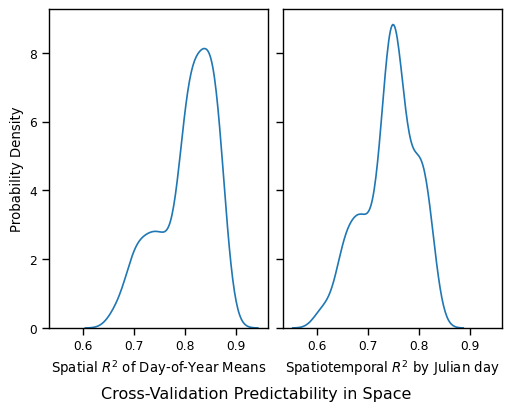

In [22]:
(fig, [ax1, ax2]) = plt.subplots(1, 2, figsize=(5, 4), layout="compressed", sharex=True, sharey=True)
sns.kdeplot(r2s, ax=ax1)
sns.kdeplot(r2st, ax=ax2)
ax2.set_ylabel(None)
ax1.set_ylabel("Probability Density")
ax1.set_xlabel("Spatial $R^2$ of Day-of-Year Means")
ax2.set_xlabel("Spatiotemporal $R^2$ by Julian day")
fig.supxlabel("Cross-Validation Predictability in Space")
plt.savefig("val_figures/spatial_skill_kde.png", dpi=1200)

#### Seasonal Spatial

Predictability of each 3S coefficient.

In [23]:
def get_ssn(day, temps):
    data = pd.DataFrame({"day": day, "temperature": temps})
    try:
        return ThreeSine.from_data(data, warn=False).to_df()
    except:
        return None  # failed fit
ssn_obs = preds.groupby("id").apply(lambda x: get_ssn(x["day"], x["temperature"]), include_groups=False)
ssn_mod = preds.groupby("id").apply(lambda x: get_ssn(x["day"], x["temp.mod"]), include_groups=False)

The 2-PC model does underpredict both the SpringSummer and FallWinter coefficients, but still outperforms the full-PC model even for high elevations, evidently due to lower overall noise. The problem here is crappy predictability for snow components, evidently.

In [ ]:
ssn_obs.describe()

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,R2,RMSE
count,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,0.0,316.000000
mean,12.951916,8.813860,325.708861,64.729430,152.414557,218.329114,0.746895,1.421557,NaN,0.849512
std,4.061042,2.721688,15.646818,33.638537,22.393217,17.375386,0.894218,0.866687,NaN,0.351832
min,3.476621,-0.249720,300.000000,1.000000,120.000000,200.000000,-0.566573,-1.470428,NaN,0.069086
25%,10.126295,6.965459,314.000000,27.500000,131.000000,200.000000,0.072737,0.854334,NaN,0.628153
50%,12.486908,9.303644,328.000000,81.000000,153.000000,217.000000,0.466002,1.438502,NaN,0.767247
75%,15.904539,10.987507,333.000000,90.000000,177.000000,238.250000,1.140043,1.931720,NaN,0.976992
max,24.413526,13.499153,365.000000,110.000000,180.000000,240.000000,3.976794,4.168251,NaN,2.683860


In [ ]:
ssn_mod_dir = NEXT.coef_est.predict_all_coefficients(
    model.model,
    NEXT.coef_est.preprocess(test_data)
).drop(columns=["at_coef", "elev", "lat", "lon"]).set_index("id")

In [ ]:
ssn_mod_dir.describe()

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter
count,320.000000,320.000000,3.200000e+02,320.000000,3.200000e+02,3.200000e+02,320.000000,320.000000
mean,12.796166,8.749417,3.267546e+02,69.598455,1.540706e+02,2.177068e+02,0.778438,1.437867
std,3.979076,2.113989,1.707973e-12,16.634709,9.109191e-13,7.116556e-13,0.733729,0.823786
min,0.828376,3.097455,3.267546e+02,-6.870923,1.540706e+02,2.177068e+02,-0.508463,-0.132420
25%,9.990104,7.293679,3.267546e+02,56.905010,1.540706e+02,2.177068e+02,0.277546,0.996218
50%,12.552935,9.021910,3.267546e+02,75.049658,1.540706e+02,2.177068e+02,0.570120,1.290156
75%,15.641032,10.311706,3.267546e+02,82.330261,1.540706e+02,2.177068e+02,1.198809,1.700124
max,24.130675,13.209055,3.267546e+02,93.431250,1.540706e+02,2.177068e+02,3.752323,9.453933


Here, we see more expected behavior. Spatial skill is highly variable, ranging from just 3.4% (SummerDay) to 86% (Intercept). It's just that the low-skill coefficients don't contribute much; Intercept (86%) and Amplitude (56%) must dominate variability. We should also look at the NSE to see which ones are actually worth predicting.

With the two-PCA, skill ranges from 1.9% (SummerDay) to 88% (Intercept). Mean and median are, unsurprisingly, lower, at 26% and 11%.  Three-PCA does substantially improve skill for some of the seasonal anomaly terms. Adding a fourth PC brings a further slight improvement to anomaly magnitude skill. Six-PCA makes further marginal improvements to SpringSummer and FallWinter, at the expense of SpringDay and SummerDay.  The original setup has far higher skill for FallWinter, in particular, and a little better in SpringSummer, despite somewhat worse overall performance.

In [ ]:
fits = pd.Series({
    nm: ssn_obs[nm].corr(ssn_mod_dir[nm])**2  # hand-verified they are all positive
    for nm in ssn_obs.columns
    if not nm in ["R2", "RMSE"]
})
fits

/u/wy/ch/dphilippus/.conda/envs/next/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/u/wy/ch/dphilippus/.conda/envs/next/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Intercept       0.919564
Amplitude       0.624732
FallDay              NaN
WinterDay       0.355612
SpringDay            NaN
SummerDay            NaN
SpringSummer    0.490888
FallWinter      0.219639
dtype: float64

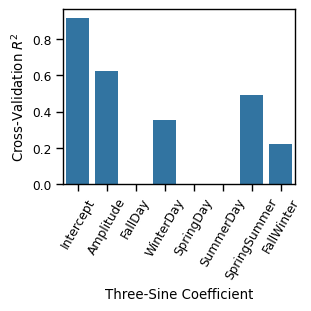

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), layout="compressed")
sns.barplot(fits, ax=ax)
ax.set_xlabel("Three-Sine Coefficient")
ax.set_ylabel("Cross-Validation $R^2$")
plt.xticks(rotation=60)
plt.savefig("val_figures/skill_3s.png", dpi=1200)

In [ ]:
def nse(sim, obs):
    mse = np.mean((sim - obs)**2)
    ovar = obs.var()
    return 1 - mse/ovar
nses = pd.Series({
    nm: nse(ssn_mod_dir[nm], ssn_obs[nm])
    for nm in ssn_obs.columns
    if not nm in ["R2", "RMSE"]
})
nses

Intercept       0.919017
Amplitude       0.624930
FallDay        -0.001302
WinterDay       0.327661
SpringDay      -0.002304
SummerDay       0.001882
SpringSummer    0.476121
FallWinter     -0.010086
dtype: float64

In [ ]:
# Add 1:1 plot
comb = ssn_mod_dir.iloc[:, :8].melt(ignore_index=False).rename(columns={"value": "mod"}).merge(
    ssn_obs.iloc[:, :8].melt(ignore_index=False).rename(columns={"value": "obs"}),
    on=["id", "variable"])

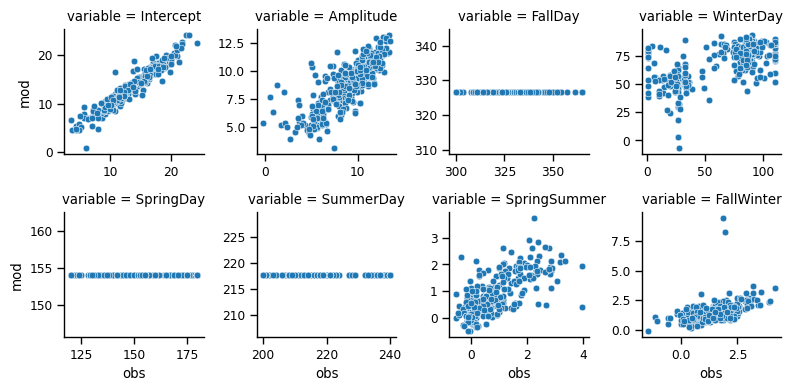

In [ ]:
sns.relplot(comb, x="obs", y="mod", col="variable", col_wrap=4, facet_kws={"sharex": False, "sharey": False},
           height=2)

We'd expect dates to be mean-biased, since those are fixed to the mean (in the model) if the anomaly is weak. The four dates are basically noise, and I suspect we would be better off just fixing all four. Otherwise:

- Intercept does quite well.
- Amplitude does reasonably well.
- FallWinter does pretty well except for two outliers.
- SpringSummer does okay.

Oddly, the results are *very* different if we fit seasonality vs predicting seasonality. Using the coefficients directly, all terms do quite well. Computing them from the predicted timeseries... not so much, which is weird. In particular, reverse-engineering them tends to predict very low SpringSummer and FallWinter coefficients. It's unclear what's going on there.

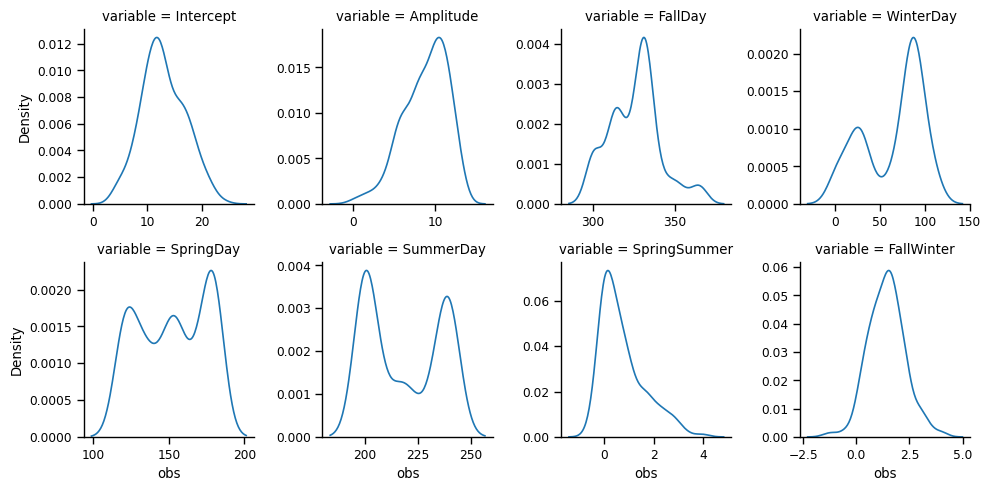

In [ ]:
sns.displot(comb, x="obs", col="variable", col_wrap=4, kind="kde", facet_kws={"sharex": False, "sharey": False}, height=2.5)

### Good/Bad Sites

This allows you to look at the best- and worst-performing test set sites on a map and cluster analysis and see if anything is going on.

In [ ]:
ranked = perf.sort_values("RMSE")
best = ranked.iloc[:100].assign(title = ["best" + str(ix) for ix in range(1,101)])
worst = ranked.iloc[-100:].assign(title = ["worst" + str(ix) for ix in range(100, 0, -1)])
midpt = int(len(ranked) / 2)
mid = ranked.iloc[(midpt-50):(midpt+50)].assign(title = ["middle" + str(ix) for ix in range(1, 101)])
comb = pd.concat([best, worst, mid])[["lat", "lon", "title"]]
comb["id"] = comb["title"]
pts = [shapely.Point(x.lon, x.lat) for x in comb.itertuples()]
comb = gpd.GeoDataFrame(data=comb, geometry=pts, crs=4326)
# comb.to_file("goodbadsites.json", driver='GeoJSON')

#### Quantifications

In [ ]:
best.describe()

,lat,lon,level_3,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,100.000000,100.000000,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,40.153798,-93.120263,0.0,0.925195,1.640105,0.897051,0.974570,0.917149,0.495762,1.931007,0.228685,1.227514
std,4.718331,17.026700,0.0,0.055361,0.160007,0.086839,0.017815,0.038230,0.298830,4.310181,0.491947,0.677587
min,28.332787,-124.058144,0.0,0.704591,1.191192,0.527846,0.896933,0.796635,-0.481969,-9.730693,-1.011765,0.172191
25%,37.799164,-107.669376,0.0,0.900669,1.562979,0.876657,0.966503,0.890290,0.322732,-0.473881,-0.071765,0.768869
50%,41.105001,-84.918458,0.0,0.940965,1.676176,0.925355,0.977726,0.926865,0.619763,1.693340,0.225113,1.062537
75%,42.839167,-80.169771,0.0,0.964970,1.760734,0.955555,0.986955,0.946013,0.700298,4.479086,0.573191,1.525822
max,48.708143,-71.609509,0.0,0.982290,1.856214,0.979604,0.997463,0.980570,0.833758,13.162841,1.341194,3.512244


In [ ]:
worst.describe()

,lat,lon,level_3,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,100.000000,100.000000,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,40.246400,-100.703251,0.0,0.800243,3.323445,-1.531143,0.979879,0.890581,-0.125705,2.952357,0.055087,3.784710
std,4.946908,17.300377,0.0,0.214534,1.227744,11.962166,0.024729,0.123350,1.569633,21.052821,1.824865,2.219187
min,29.952733,-124.357089,0.0,0.043903,2.456807,-109.672987,0.824755,0.339466,-10.598032,-38.357194,-3.867501,0.387610
25%,36.694053,-119.541493,0.0,0.783008,2.601795,0.458210,0.978207,0.897676,-0.199577,-8.810650,-1.104861,1.982799
50%,39.546614,-104.031656,0.0,0.875275,2.925872,0.790467,0.985998,0.930720,0.253541,-2.134245,-0.299534,3.593758
75%,44.538357,-84.543153,0.0,0.924374,3.444432,0.872098,0.991956,0.952431,0.539392,11.577208,1.220721,4.764625
max,48.984601,-67.935278,0.0,0.968869,8.135228,0.931548,0.999155,0.995276,0.830215,125.246483,5.702966,11.135823


#### Classification Analysis

We'll use scikit-learn's Random Forest ensemble, since that's both simple and flexible.  70/30 train/test.

In [ ]:
allbw = pd.DataFrame({"id": pd.concat([best["id"], mid["id"], worst["id"]]), "rank": ["best"] * 100 + ["mid"] * 100 + ["worst"] * 100}
                    ).merge(NEXT.coef_est.preprocess(test_data), on="id"
                           ).drop(columns=["level_1_x", "level_1_y", "date", "day"])
train = allbw.groupby("rank").sample(n=70)
test = allbw.loc[-allbw["id"].isin(train["id"]),:]
getX = lambda x: x.drop(columns=["id", "rank"])
getY = lambda x: x["rank"]
# test = test.loc[test["rank"] != "mid",:]
# train = train.loc[train["rank"] != "mid", :]

In [ ]:
rf = RandomForestClassifier().fit(getX(train), getY(train))
rf.score(getX(train), getY(train))

1.0

In [ ]:
rf.score(getX(test), getY(test))

0.4222222222222222

Accuracy is 42% (correctly classified).  Proportion correctly classified by chance should be 1/3. This accuracy is worse than it was with the all-PC model, so dropping PCs increases the randomness of performance.

## Reforecast (heterogeneous)

Note that the time period is not the same as the hindcast test, due to limited HRRR archive coverage.

Data retrieval uses the *earliest* HRRR run covering a given date (i.e., 48 hours out), so this is a 2-day forecast lead time (it uses this morning's forecast - where today's max temperature is itself one day of forecast - to predict tomorrow).

For comparison purposes here, the median R2 of pure climatology (i.e., fitted seasonality) is 0.90.  Stationarity probably does better than NEXT, but stationarity isn't actually available in an ungaged context - though, of course, neither is climatology!

RMSE did increase a fair bit, to 2.9 C.  That seems to be driven by an increase in bias (to 8%/1.0 C), which probably has to do with the heterogeneous training data.  (Next up: pull HRRR for the full dataset and do a homogeneous run.)  Still, the R2 is better than climatology at 0.92.  (See below: it's the heterogeneity.)  The PCA, GAM-sensitivity version did a bit better than the original here.

2-PC version has a much lower penalty here, with an RMSE of 2.6 C.

5-PC/constant-dates has an even lower penalty, with RMSE 2.5 C.

In [ ]:
def predict(ws):
    print("|", end="")
    try:
        return model.run(ws, reset=True)
    except:
        return None

In [ ]:
ppath = bp + f"results/TestSet_reforecast{coef_variant}.csv"
if not rerun and os.path.exists(ppath):
    preds = pd.read_csv(ppath, dtype={"id": "str"}, parse_dates=["date"])
else:
    start = time.time()
    with warnings.catch_warnings(action="ignore"):
        preds = test_data_hrrr.groupby("id").apply(predict, include_groups=False).reset_index().drop(columns="level_1")
    runtime = int(time.time() - start)
    print(f"Took {runtime} seconds to predict")
    preds.to_csv(ppath, index=False)

In [ ]:
with warnings.catch_warnings(action="ignore"):
    perf = preds.groupby(["id", "lat", "lon"]).apply(NEWT.analysis.perf_summary, include_groups=False).reset_index()
perf.describe()

,lat,lon,level_3,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,303.000000,303.000000,303.0,303.000000,303.000000,303.000000,303.000000,303.000000,298.000000,303.000000,303.000000,303.000000
mean,39.907014,-95.509951,0.0,0.876521,2.746486,-0.568640,0.978460,0.929910,0.277901,6.212930,0.724002,2.565321
std,4.677083,17.366814,0.0,0.145726,1.150521,15.060968,0.020466,0.071562,0.663656,15.635399,1.688010,1.913583
min,28.332787,-124.357089,0.0,0.000124,1.237399,-255.614842,0.824468,0.335259,-9.985853,-58.941521,-5.741736,0.185475
25%,36.610189,-111.746329,0.0,0.869279,2.075929,0.720342,0.972174,0.920568,0.217900,-1.269083,-0.174649,1.143194
50%,40.036652,-88.156111,0.0,0.921275,2.490239,0.837572,0.981786,0.945719,0.356930,5.516970,0.733471,2.024977
75%,43.349958,-81.273662,0.0,0.945128,3.112915,0.913884,0.991419,0.961289,0.483387,12.665136,1.652165,3.427651
max,48.984601,-67.935278,0.0,0.981248,12.863081,0.970566,0.999801,1.000000,0.725311,86.096074,9.711619,11.192170


## Reforecast (homogeneous)

Note that the time period is not the same as the hindcast test, due to limited HRRR archive coverage.

Data retrieval uses the *earliest* HRRR run covering a given date (i.e., 48 hours out), so this is a 2-day forecast lead time (it uses this morning's forecast - where today's max temperature is itself one day of forecast - to predict tomorrow).

For comparison purposes here, the median R2 of pure climatology (i.e., fitted seasonality) is 0.90.  Stationarity probably does better than NEXT, but stationarity isn't actually available in an ungaged context - though, of course, neither is climatology!

It does better with a homogeneous reforecast; RMSE decreases to 2.3 C.  R2 doesn't change.

In [ ]:
start = time.time()
with warnings.catch_warnings(action="ignore"):
    model = NEXT.NEXT.from_data(dev_data_hrrr.dropna())
runtime = int(time.time() - start)
print(f"Took {runtime} seconds to train")

Took 85 seconds to train


In [ ]:
model.to_pickle("coefs_hrrr.pickle")

In [ ]:
def predict(ws):
    print("|", end="")
    return model.run(ws, reset=True)

In [ ]:
ppath = bp + f"results/TestSet_reforecast_homog{coef_variant}.csv"
if not rerun and os.path.exists(ppath):
    preds = pd.read_csv(ppath, dtype={"id": "str"}, parse_dates=["date"])
else:
    start = time.time()
    with warnings.catch_warnings(action="ignore"):
        preds = test_data_hrrr.groupby("id").apply(predict, include_groups=False).reset_index().drop(columns="level_1")
    runtime = int(time.time() - start)
    print(f"Took {runtime} seconds to predict")
    preds.to_csv(ppath, index=False)

In [ ]:
with warnings.catch_warnings(action="ignore"):
    perf = preds.groupby(["id", "lat", "lon"]).apply(NEWT.analysis.perf_summary, include_groups=False).reset_index()
perf.describe()

,lat,lon,level_3,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,303.000000,303.000000,303.0,303.000000,303.000000,303.000000,303.000000,303.000000,298.000000,303.000000,303.000000,303.000000
mean,39.907014,-95.509951,0.0,0.879082,2.503932,-0.056765,0.978460,0.929910,0.309071,2.342857,0.168824,3.006313
std,4.677083,17.366814,0.0,0.145600,1.046128,9.216916,0.020466,0.071562,0.200800,13.264259,1.412903,1.984103
min,28.332787,-124.357089,0.0,0.029582,1.149414,-154.148186,0.824468,0.335259,-0.989370,-43.891175,-5.269627,0.184219
25%,36.610189,-111.746329,0.0,0.876523,1.921817,0.787731,0.972174,0.920568,0.233359,-4.133063,-0.513333,1.408432
50%,40.036652,-88.156111,0.0,0.922317,2.317475,0.871676,0.981786,0.945719,0.341760,1.771871,0.224129,2.642291
75%,43.349958,-81.273662,0.0,0.946780,2.743822,0.920383,0.991419,0.961289,0.436091,6.823344,0.920019,4.027361
max,48.984601,-67.935278,0.0,0.981154,12.405471,0.971037,0.999801,1.000000,0.674187,86.625591,8.556368,9.777739


## Uncertainty

In [ ]:
def predict(ws, Nco=100, Nanom=10):
    print("|", end="")
    try:
        out = None
        for i in range(Nco):
            res = model.run(ws, draw=True, reset=True, quantiles=Nanom)
            minires = res.loc[:, res.columns.str.startswith("temp.mod_")]
            minires.columns = [x + f"_{i}" for x in minires.columns]
            if out is None:
                out = res[["date", "temperature"]]
            out = pd.concat([out, minires], axis=1)
        return out
    except Exception as e:
        print(e)
        return None

In [ ]:
ppath = bp + f"results/TestSet_hindcast_uncertainty{coef_variant}.csv"
if not rerun and os.path.exists(ppath):
    preds = pd.read_csv(ppath, dtype={"id": "str"}, parse_dates=["date"])
else:
    start = time.time()
    with warnings.catch_warnings(action="ignore"):
        preds = test_data.groupby("id").apply(predict, include_groups=False
                                             ).reset_index().drop(columns="level_1")
    runtime = int(time.time() - start)
    print(f"Took {runtime} seconds to predict")
    preds.to_csv(ppath, index=False)
values = pd.concat([preds[["id", "date", "temperature"]], preds.loc[:, preds.columns.str.startswith("temp.mod_")]], axis=1)

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||Took 3329 seconds to predict


In [23]:
def brier(site_preds):
    array = xr.DataArray(
        site_preds.loc[:, site_preds.columns.str.startswith("temp.mod_")],
        dims=["x", "ensemble"],
        coords={"ensemble": range(len(site_preds.columns)-2), "x": range(len(site_preds))}
    )
    obs = xr.DataArray(site_preds["temperature"],
                       dims=["x"],
                       coords={"x": range(len(site_preds))})
    minv = ceil(obs.min())
    maxv = floor(obs.max())
    if maxv > minv:
        thres = np.arange(minv, maxv)
    else:
        thres = [minv]
    return brier_score_for_ensemble(array,
                                    obs,
                                    event_thresholds=thres,
                                    ensemble_member_dim="ensemble").to_pandas()

In [13]:
scores = pd.DataFrame(values.groupby("id").apply(brier, include_groups=False).rename("Score"))

Brier scores here are generally quite good - a perfect score is 0 (worst is 1), and even with just the anomaly ensemble, the vast majority of scores are <0.1.  A ten-member x ten-member ensemble gives a median of 0.056 and 75th percentile of 0.086, compared to 0.066 and 0.098 with just anomaly ensemble.  Global performance is similar, but excessively demanding with a large-scale run, and so not run here.  Scores are nearly constant at ~0.06 across midrange thresholds (5-25 C), and better near the extremes.  That's the MSE of 0/1 (exceeds/not exceeds), so it's on the wrong side 6% of the time.  Performance is almost identical with a full-sized ensemble.

With the adjusted ensemble approach (including noise), the median score drops to ~0.05, with a maximum median across thresholds of ~0.06. Similar for 2-PC. However, 2-PC develops a trend of worse performance at higher thresholds.

With the 5-PC interacting model, median Brier score is 0.049, IQR 0.034-0.067.

In [14]:
scores.describe()

,Score
count,7370.000000
mean,0.055789
std,0.041718
min,0.000000
25%,0.034487
50%,0.048884
75%,0.067338
max,0.575017


In [15]:
scores.groupby("threshold").median().describe()

,Score
count,33.000000
mean,0.045301
std,0.011357
min,0.000702
25%,0.044942
50%,0.048974
75%,0.051551
max,0.054899


<Axes: xlabel='threshold', ylabel='Score'>

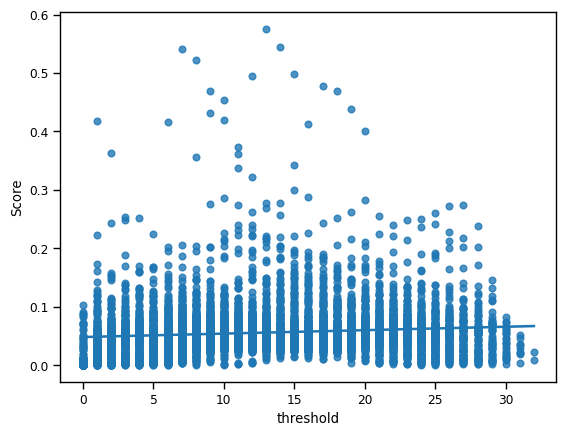

In [16]:
sns.regplot(scores.reset_index(), x="threshold", y="Score")

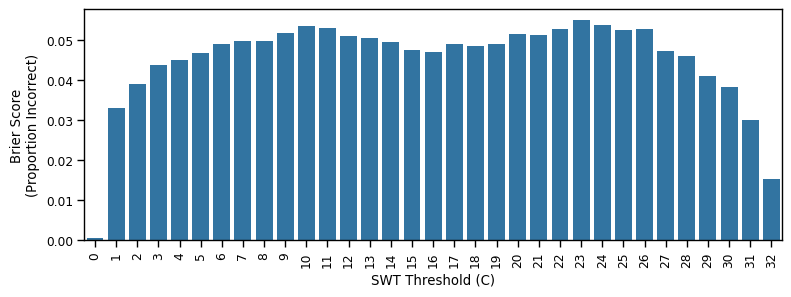

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(9, 3))
sns.barplot(scores.groupby("threshold").median(), x="threshold", y="Score", ax=ax)
ax.set_xlabel("SWT Threshold (C)")
ax.set_ylabel("Brier Score\n(Proportion Incorrect)")
_ = plt.xticks(rotation=90)

### Annual Threshold Skill

We're concerned with: annual max daily, 7-day, and 30-day mean. To work with the above Brier score code, all the column names need to stay the same.

For annual max daily, the median Brier score, across years and thresholds, is 0.07, ranging from 0.0005-0.19. Median Brier scores across thresholds are very low up to 10 C (<0.01), increase steadily up to 25 C (0.16), and then decrease again up to 32 C (0.01).

In [18]:
dmax = values.assign(date=lambda x: x.date.dt.year).groupby(["id", "date"], as_index=False).max().groupby("date").apply(brier, include_groups=False).rename("Score")
dmax.describe()

count    209.000000
mean       0.069924
std        0.051470
min        0.000458
25%        0.019423
50%        0.066984
75%        0.112180
max        0.185535
Name: Score, dtype: float64

<Axes: xlabel='threshold'>

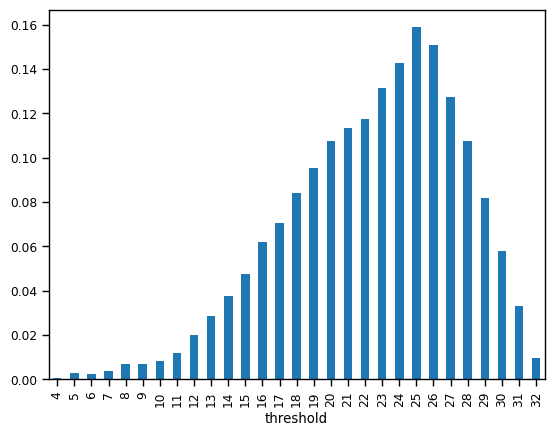

In [20]:
dmax.groupby("threshold").median().plot.bar()

In [26]:
d7max = values.assign(date=lambda x: x.date.dt.year).groupby(["id", "date"], as_index=False).rolling(7).mean().groupby(["id", "date"], as_index=False).max().groupby("date").apply(brier, include_groups=False).rename("Score")
d7max.describe()

count    212.000000
mean       0.061757
std        0.045381
min        0.000317
25%        0.017393
50%        0.059134
75%        0.100800
max        0.151436
Name: Score, dtype: float64

<Axes: xlabel='threshold'>

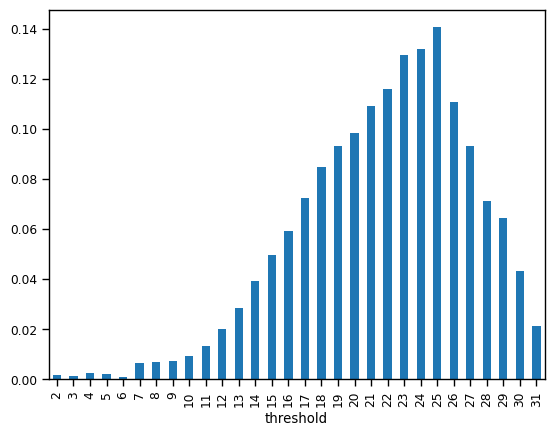

In [27]:
d7max.groupby("threshold").median().plot.bar()

In [28]:
d30max = values.assign(date=lambda x: x.date.dt.year).groupby(["id", "date"], as_index=False).rolling(30).mean().groupby(["id", "date"], as_index=False).max().groupby("date").apply(brier, include_groups=False).rename("Score")
d30max.describe()

count    203.000000
mean       0.057887
std        0.039654
min        0.000491
25%        0.019147
50%        0.058507
75%        0.090755
max        0.140001
Name: Score, dtype: float64

<Axes: xlabel='threshold'>

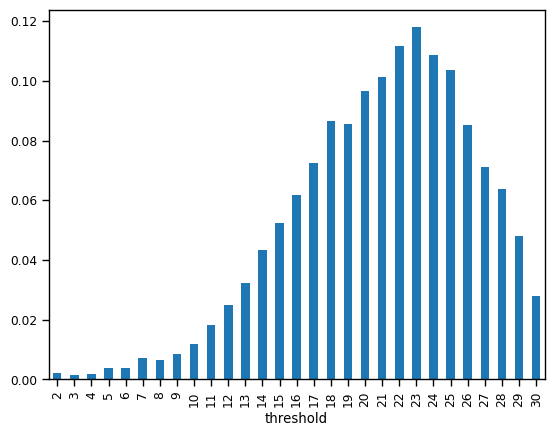

In [ ]:
d30max.groupby("threshold").median().plot.bar()

### Interval Width

5-PC reference version with a noise factor of 1.0:

- 50% CI: a little over-conservative at a median width of 3.7 (3.3-4.1) C. 59% of observations are in the CI overall, and at least 50% of observations are in it for 75% of sites.
- 90% CI: also a bit conservative with a median width of 8.8 (8.0-9.7) C. Captures 93% of obs, and at least 90% of obs for 80% of sites.
- 95% CI: still conservative with a median width of 10.7 (9.6-11.9) C capturing 96% of obs. At least 95% for 79%.

In [40]:
size = 0.95
widths = values.loc[:, ["id", "date"]]
widths["upper"] = values.iloc[:, 3:].apply(lambda x: np.quantile(x, (1+size)/2), axis=1)
widths["lower"] = values.iloc[:, 3:].apply(lambda x: np.quantile(x, (1-size)/2), axis=1)
widths["median"] = values.iloc[:, 3:].apply(lambda x: np.quantile(x, 0.5), axis=1)
widths["width"] = widths["upper"] - widths["lower"]

In [ ]:
widths.describe()

,date,upper,lower,median,width
count,842449,842449.000000,842449.000000,842449.000000,842449.000000
mean,2019-02-25 21:26:43.714408960,19.052750,8.317758,13.463947,10.734993
min,2015-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000
25%,2017-04-11 00:00:00,12.969846,2.372187,7.783416,9.638542
50%,2019-03-21 00:00:00,18.739326,7.946715,13.289267,10.694972
75%,2021-02-03 00:00:00,24.930729,13.475335,19.145512,11.872418
max,2022-12-31 00:00:00,46.987106,26.483944,32.407514,46.985485
std,NaN,7.551061,6.375732,7.133814,2.317053


In [ ]:
widths["obs"] = values["temperature"]
widths["isin"] = (widths["obs"] <= widths["upper"]) & (widths["obs"] >= widths["lower"])

In [ ]:
widths.groupby("id")["isin"].mean().describe()

count    320.000000
mean       0.964942
std        0.066086
min        0.461829
25%        0.957871
50%        0.986796
75%        0.996924
max        1.000000
Name: isin, dtype: float64

In [ ]:
(widths.groupby("id")["isin"].mean() < size).mean()

0.20625

### Example Plots

In [45]:
which_sites = pd.Series(values["id"].unique()).sample(n=8)
sample = values.loc[values["id"].isin(which_sites)].melt(["id", "date", "temperature"])
sample

,id,date,temperature,variable,value
0,01640975,2015-01-01,2.9,temp.mod_0.09_0,2.371682
1,01640975,2015-01-02,3.0,temp.mod_0.09_0,2.194441
2,01640975,2015-01-03,3.0,temp.mod_0.09_0,2.089894
3,01640975,2015-01-04,3.4,temp.mod_0.09_0,2.511515
4,01640975,2015-01-05,2.8,temp.mod_0.09_0,3.094550
...,...,...,...,...,...
20530995,14153500,2022-12-27,7.8,temp.mod_0.91_99,9.701043
20530996,14153500,2022-12-28,7.6,temp.mod_0.91_99,9.364513
20530997,14153500,2022-12-29,7.6,temp.mod_0.91_99,8.836248
20530998,14153500,2022-12-30,7.8,temp.mod_0.91_99,8.703594


Excellent! With the new (overly-conservative) version, we do see wide ranges. We also see the occasional "stray" ensemble member, as one would expect.

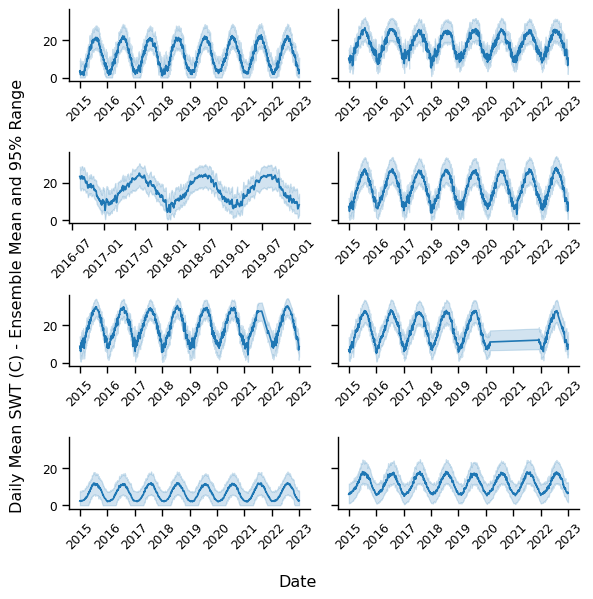

In [46]:
g = sns.relplot(sample,
            x="date",
            y="value",
            col="id",
            col_wrap=2,
            height=1.5,
            aspect=2,
            kind="line",
            facet_kws={"sharex": False},
            errorbar='pi').tick_params(axis='x', rotation=45)
g.set_axis_labels("", "")
g.set_titles("")
g.fig.supxlabel("Date")
g.fig.supylabel("Daily Mean SWT (C) - Ensemble Mean and 95% Range")
g.tight_layout()
g.savefig("val_figures/ensemble_plots.png", dpi=1200)

# Gagewise Cross-Validation

Runtime: 1.9 hours for 930 sites and ~3M observations.  That makes >1.5 years/second, assuming most of the time is prediction, and a total of 7.5 seconds per site.

With no modification engines, it is 0.43 hours, making 1.7 seconds/site and >5 years/second.

With full-series runs and GAM-sensitivity, training still takes a few minutes, but prediction is almost instantaneous.  It still takes 0.4 hours total, suggesting that runtime is dominated by model training.  Oddly, performance is not improved by the GAM-sensitivity.

In [ ]:
# Modbuilder: data -> (ws -> prediction)
logfile = bp + "results/kfold_log.txt"
def make_modbuilder(use_clim, lookback):
    def next_modbuilder(data):
        nx = NEXT.NEXT.from_data(data)
        def prd(x):
            print("|", end="")
            # return nx.run(x, reset=True, use_climate=use_clim, climyears=lookback)
            try:
                # return nx.make_newt(x, reset=True, use_climate=use_clim, climyears=lookback).get_newt().coefs_to_df()
                return nx.run(x, reset=True, use_climate=use_clim, climyears=lookback)
                # mod = nx.make_newt(x, reset=True, use_climate=use_clim, climyears=lookback).get_newt()
                # mod.dynamic_engine = None
                # return mod.run_series(x)
            except KeyboardInterrupt as e:
                raise e
            except Exception as e:
                print("Error", end="")
                with open(logfile, "a") as lf:
                    lf.write(f"Error in gage {x["id"].iloc[0]} for use_clim={use_clim} and lookback={lookback}: {e}\n")
                return None
        return prd
    return next_modbuilder

In [ ]:
clim = False
lookback = 10
timing = bp + "results/kfold_times.txt"
out = bp + f"results/kfold_pca{coef_variant}.csv"
with warnings.catch_warnings(action="ignore"):
    start = time.time()
    kfr = NEWT.analysis.kfold(dev_data, make_modbuilder(clim, lookback), output=out, redo=rerun)
    print(f"\nLookback: {lookback} : {(time.time() - start) / 3600: .2f} hours for {len(dev_data["id"].unique())} sites with {len(dev_data)} observations")


Lookback: 10 :  0.01 hours for 928 sites with 2986986 observations


In [ ]:
with warnings.catch_warnings(action="ignore"):
    perf = kfr.groupby(["id", "lat", "lon"]).apply(NEWT.analysis.perf_summary, include_groups=False).reset_index()
perf.describe()

,lat,lon,level_3,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,928.000000,928.000000,928.0,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000
mean,40.024700,-93.773787,0.0,0.901833,2.361570,0.444312,0.976446,0.914497,0.427750,3.483845,0.250006,2.732638
std,4.522685,17.162228,0.0,0.119249,1.136775,5.407483,0.017759,0.066951,0.263208,13.036646,1.463927,1.882015
min,26.975000,-124.392987,0.0,0.005268,1.072288,-156.661711,0.858323,0.175511,-3.780280,-67.156417,-19.687600,0.068957
25%,37.730899,-109.882554,0.0,0.897391,1.790373,0.796355,0.969363,0.900950,0.310250,-3.008872,-0.404047,1.285418
50%,40.132276,-86.485407,0.0,0.936750,2.097592,0.897099,0.980235,0.928521,0.481190,1.836364,0.252302,2.336321
75%,42.986410,-79.563692,0.0,0.955217,2.635046,0.934135,0.988397,0.949401,0.605652,7.440672,0.901863,3.718536
max,48.998814,-67.803889,0.0,0.982032,20.538477,0.980479,0.999005,0.988499,0.774728,124.329258,5.655700,18.866046


FWPCA:

- All PCs: R2 0.94, RMSE 2.1, NSE 0.90, anomaly 0.49, maxmiss 2.4, spatial predictability 0.78 (0.62-0.87) and 0.73 (0.60-0.82).
- Five PCs: R2 0.94, RMSE 2.1, NSE 0.90, anomaly 0.56, maxmiss 2.0, spatial 0.78 (0.62-0.86) and 0.73 (0.61-0.82).
- Two PCs: R2 0.93, RMSE 2.1, NSE 0.9, anomaly 0.56, maxmiss 2.0, spatial 0.79 (0.63-0.86) and 0.73 (0.61-0.81).
- Three PCs, fixed dates: R2 0.94, RMSE 2.1, NSE 0.9, anomaly 0.57, maxmiss 2.0, spatial 0.78 (0.62-0.86) and 0.72 (0.61-0.82).
- Four PCs, fixed dates: R2 0.94, RMSE 2.1, NSE 0.90, anomaly 0.57, maxmiss 2.1, spatial 0.79 (0.62-0.86) and 0.73 (0.61-0.82).
- Six PCs, fixed dates: R2 0.94, RMSE 2.1, NSE 0.90, anomaly 0.56, maxmiss 2.1, spatial 0.79 (0.62-0.86) and 0.73 (0.61-0.83).
- Two PCs, restricted variables: R2 0.93, RMSE 2.2, NSE 0.90, anomaly 0.56, maxmiss 2.1, spatial 0.76 (0.62-0.83) and 0.71 (0.60-0.79). Other performance is *atrocious*.
- Two PCs, fixed dates: R2 0.93, RMSE 2.1, NSE 0.90, anomaly 0.57, maxmiss 2.1, spatial 0.78 (0.62-0.86) and 0.73 (0.61-0.81).

Not FW, but interacting:

- All PCs, fixed dates: R2 0.94, RMSE 2.2, NSE 0.89, anomaly 0.48, maxmiss 2.4, spatial 0.77 (0.60-0.86) and 0.72 (0.59-0.82). FallWinter performance is far better (0.36), SpringSummer is still bad.
- Five PCs, constant dates: R2 0.94, RMSE 2.1, NSE 0.90, anomaly 0.48, maxmiss 2.3, spatial 0.78 (0.61-0.88) and 0.72 (0.60-0.83).

## Plots

In [ ]:
states = gpd.read_file("usa_states/cb_2018_us_state_20m.shp")
states = states[-states["STUSPS"].isin(["AK", "HI", "PR"])]

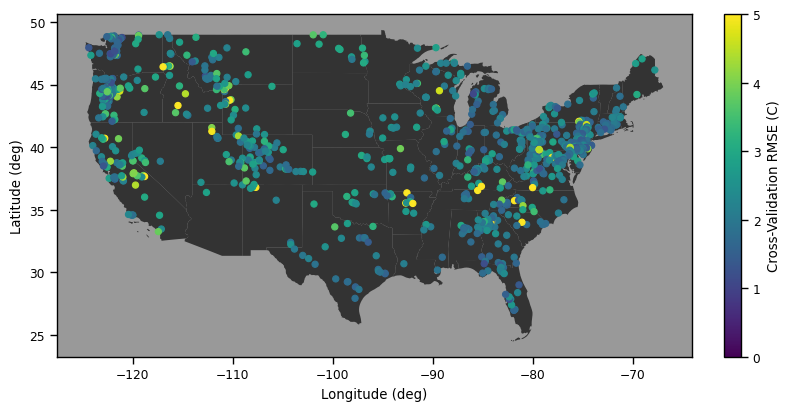

In [ ]:
fig = plt.figure(figsize=(8, 4), layout="compressed")
ax = plt.axes(facecolor="#999")
states.plot(ax=ax, color="#333")
perf.plot.scatter(x="lon", y="lat", c="RMSE", ax=ax, colormap="viridis", vmin=0, vmax=5)
cb = ax.collections[1].colorbar
cb.set_label("Cross-Validation RMSE (C)")
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Latitude (deg)")
plt.savefig("val_figures/conus_rmse.png", dpi=1000)

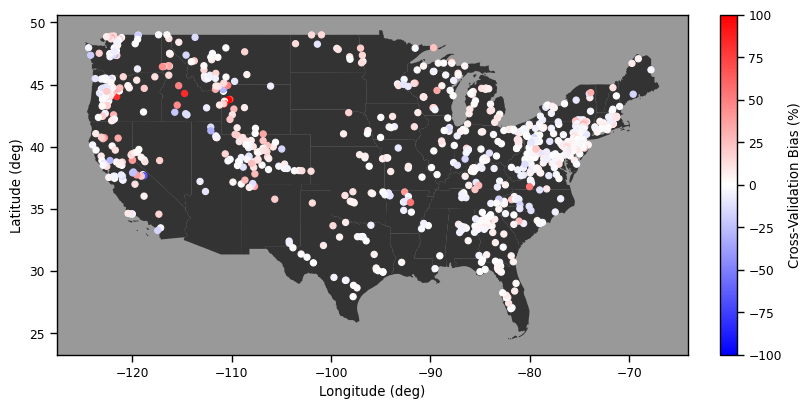

In [ ]:
fig = plt.figure(figsize=(8, 4), layout="compressed")
ax = plt.axes(facecolor="#999")
states.plot(ax=ax, color="#333")
perf.plot.scatter(x="lon", y="lat", c="Pbias", ax=ax, colormap="bwr", vmin=-100, vmax=100)
cb = ax.collections[1].colorbar
cb.set_label("Cross-Validation Bias (%)")
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Latitude (deg)")
plt.savefig("val_figures/conus_bias.png", dpi=1000)

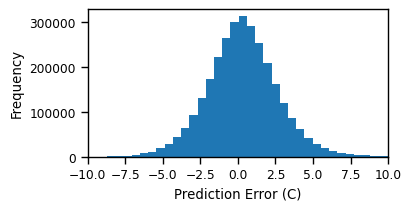

In [ ]:
fig = plt.figure(figsize=(4, 2), layout="compressed")
ax = plt.axes()
kfr["error"] = kfr["temp.mod"] - kfr["temperature"]
kfr["error"].plot.hist(bins=100, ax=ax)
ax.set_xlim(-10, 10)
ax.set_xlabel("Prediction Error (C)")
plt.savefig("val_figures/ErrorHist_xv.png", dpi=1000)

In [ ]:
ecos = gpd.read_file("ecoregions/NA_CEC_Eco_Level1.shp").to_crs(4326)

In [ ]:
def get_name(df):
    if len(df) > 0:
        return df.iloc[0]["NA_L1NAME"].title()
    else:
        return "NA"
perf_pts = gpd.GeoSeries([shapely.Point(x.lon, x.lat) for x in perf.itertuples()])
pt_ecos = pd.Series([get_name(ecos[ecos.contains(x)]) for x in perf_pts])

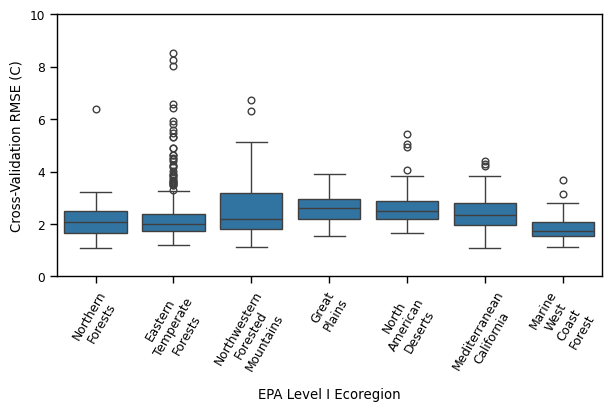

In [ ]:
fig = plt.figure(figsize=(6, 4), layout="compressed")
ax = plt.axes()
perf["ecoregion"] = [x.replace(" ", "\n") for x in pt_ecos]
sns.boxplot(perf[perf["ecoregion"] != "NA"], y="RMSE", x="ecoregion", ax=ax)
plt.xticks(rotation=60)
ax.set_ylim(0, 10)
ax.set_xlabel("EPA Level I Ecoregion")
ax.set_ylabel("Cross-Validation RMSE (C)")
plt.savefig("val_figures/EcoregionRMSEBox.png", dpi=1000)

In [ ]:
perf[perf["RMSE"] > 10]

,id,lat,lon,level_3,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss,ecoregion
562,06036940,44.732725,-110.713253,0,0.793687,14.780918,-10.900360,0.917760,0.824984,0.240751,-67.156417,-14.645836,15.879419,Northwestern\nForested\nMountains
730,10265150,37.668822,-118.817631,0,0.042424,20.538477,-17.655255,0.950897,0.175511,0.043581,-65.430865,-19.687600,18.866046,North\nAmerican\nDeserts


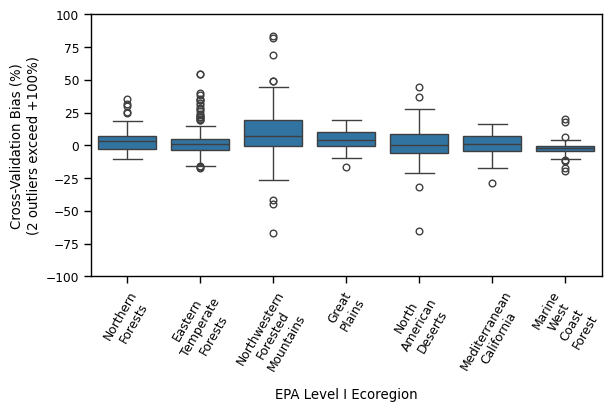

In [ ]:
fig = plt.figure(figsize=(6, 4), layout="compressed")
ax = plt.axes()
perf["ecoregion"] = [x.replace(" ", "\n") for x in pt_ecos]
sns.boxplot(perf[perf["ecoregion"] != "NA"], y="Pbias", x="ecoregion", ax=ax)
plt.xticks(rotation=60)
ax.set_ylim(-100, 100)
ax.set_xlabel("EPA Level I Ecoregion")
ax.set_ylabel("Cross-Validation Bias (%)\n(2 outliers exceed +100%)")
plt.savefig("val_figures/EcoregionBiasBox.png", dpi=1000)

# Extrapolation Tests

## Regional

For regional extrapolation, we split the CONUS into 16 grid cells (four-by-four), of which 15 actually contain gages and 14 have more than 1 gage.  Across those 14, we run a leave-one-out cross-validation, training a model on the other 13 and predicting all gages in the left-out grid cell.  This tests the ability of the model to make predictions for contiguous regions with no gages, meaning that it has no training data from nearby sites and has to go off its knowledge of general trends.

The cell 0x0 (southwesternmost) only has one gage in it, so results from that one should probably be ignored, but we'll include it.  The next fewest gages is 9, in Maine (3x3).  Some cells are, of course, considerably sparser than others, and gage count additionally varies with the size of cells on the US borders, as in the case of both 0x0 and 3x3.

In [ ]:
N = 4
latmin = all_data["lat"].min()
latmax = all_data["lat"].max() + 1
lonmin = all_data["lon"].min()
lonmax = all_data["lon"].max() + 1
latstep = (latmax - latmin)/N
lonstep = (lonmax - lonmin)/N

all_data["lat_cell"] = ((all_data["lat"] - latmin) / latstep).astype("int")
all_data["lon_cell"] = ((all_data["lon"] - lonmin) / lonstep).astype("int")
all_data["cell"] = all_data["lon_cell"].astype("str") + "x" + all_data["lat_cell"].astype("str")
sns.scatterplot(all_data.groupby("id")[["lat", "lon", "cell"]].first(), x="lon", y="lat", hue="cell")

In [29]:
def modbuilder(data):
    nx = NEXT.NEXT.from_data(data)
    print("New region", end="")
    def prd(x):
        print("|", end="")
        try:
            return nx.run(x, reset=True)
        except KeyboardInterrupt as e:
            raise e
        except:
            return None
    return prd
with warnings.catch_warnings(action="ignore"):
    spatxv = NEWT.analysis.kfold(all_data, modbuilder, by='cell', k=1, output = bp + f"results/SpatialXV{coef_variant}.csv", redo=rerun)

In [ ]:
with warnings.catch_warnings(action="ignore"):
    spatperf = spatxv.groupby(["id", "cell"]).apply(NEWT.analysis.perf_summary)

Globally, there is a negligible penalty, with RMSE at 2.3 C and R2 at 0.93.

With 2-PC, the penalty is the same, with RMSE of 2.2 C.

In [ ]:
spatperf.describe()

,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,1248.000000,1248.000000,1248.000000,1248.000000,1248.000000,1248.000000,1248.000000,1248.000000,1248.000000
mean,0.898967,2.452155,0.225496,0.976907,0.914290,0.415594,3.759248,0.327226,2.799047
std,0.122389,1.134585,8.044833,0.018095,0.069481,0.292015,13.115342,1.510198,1.952743
min,0.005346,1.125988,-240.472568,0.824755,0.175511,-4.498871,-72.787484,-19.472914,0.241480
25%,0.892876,1.858374,0.784742,0.969973,0.900802,0.306977,-2.876165,-0.359670,1.298869
50%,0.934676,2.204073,0.890649,0.980499,0.928942,0.468343,2.473869,0.304228,2.354674
75%,0.954578,2.726925,0.929578,0.988913,0.949556,0.596533,8.392182,1.057771,3.901665
max,0.981831,20.450128,0.975050,0.999155,0.996135,0.767991,118.094616,6.573084,17.738996


In [ ]:
spatperf.groupby("cell")["RMSE"].median()

cell
0x0    3.634378
0x1    2.670831
0x2    2.541869
0x3    2.181901
1x0    2.048243
1x1    2.453139
1x2    2.522207
1x3    2.942809
2x0    2.468933
2x1    2.103177
2x2    2.119981
2x3    2.271415
3x1    2.239465
3x2    2.049014
3x3    2.682956
Name: RMSE, dtype: float64

Performance does vary somewhat with region, but all have a median RMSE of 2.0-3.0 C except the one-gage one.

(0.0, 10.0)

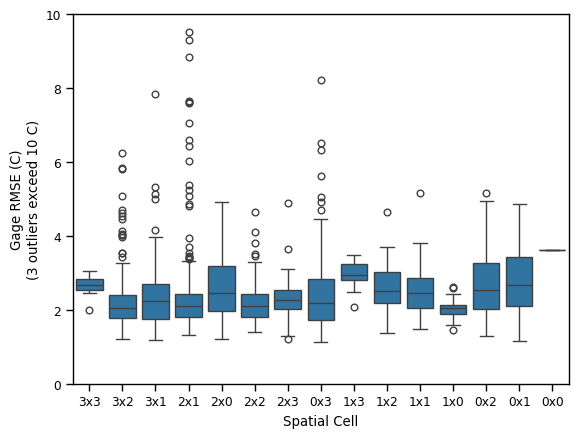

In [ ]:
ax = sns.boxplot(spatperf, x="cell", y="RMSE")
ax.set_xlabel("Spatial Cell")
ax.set_ylabel("Gage RMSE (C)\n(3 outliers exceed 10 C)")
ax.set_ylim(0, 10)

## Elevation

For elevation extrapolation, we train on the lower 95% and test on the upper 5%.  We also just plot errors by elevation.

### Non-Extrapolating

To look at bias, remove the `.abs()`.  There is no trend in bias and a modest trend in absolute error (about 2 -> 2.6 C in the combined cross-validation and test sets).  However, this seems to be because median errors are very high in the 2000-2500 m range; otherwise, there's no obvious trend.  With that group removed, the trend is present but weaker.

In [ ]:
preds = pd.read_csv(bp + f"results/TestSet_hindcast{coef_variant}.csv", dtype={"id": "str"}, parse_dates=["date"])
kfr = pd.read_csv(bp + f"results/kfold_pca{coef_variant}.csv", dtype={"id": "str"}, parse_dates=["date"])
cols = ["id", "elev_min", "date", "temp.mod", "temperature"]
preds = pd.concat([preds[cols], kfr[cols]])

In [ ]:
preds["error"] = (preds["temp.mod"] - preds["temperature"]).abs()
elev_perf = preds.groupby("id")[["elev_min", "error"]].mean()

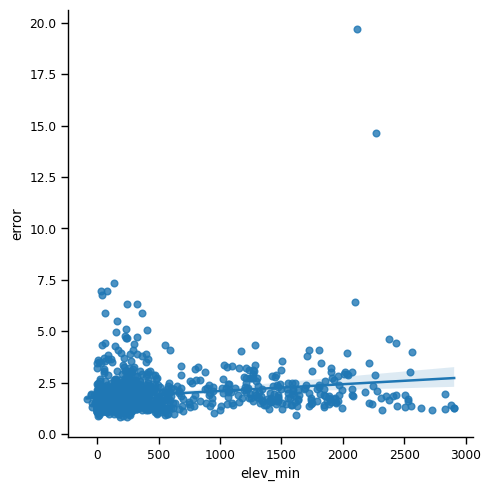

In [ ]:
sns.lmplot(elev_perf, x="elev_min", y="error")

In [ ]:
elev_perf.assign(elev_bucket = lambda x: x["elev_min"] // 500).groupby("elev_bucket").median()

,elev_min,error
elev_bucket,,
-1.0,-0.904104,1.476647
0.0,183.398407,1.650251
1.0,622.275818,1.729446
2.0,1272.117493,2.059314
3.0,1747.874878,1.893705
4.0,2225.939331,2.253216
5.0,2596.154053,1.378099


### Extrapolating

In [ ]:
all_data["elev_min"].quantile(0.95)

1804.63671875

In [ ]:
train = all_data[all_data["elev_min"] < 1800]
test = all_data[all_data["elev_min"] >= 1800].dropna()

In [ ]:
len(test["id"].unique())

73

In [ ]:
def predict(model, ws):
    print("|", end="")
    try:
        return model.run(ws, reset=True)
    except ValueError:
        return None

with warnings.catch_warnings(action="ignore"):
    model = NEXT.NEXT.from_data(train)
    prd = test.groupby("id").apply(lambda x: predict(model, x), include_groups=False).reset_index().drop(columns="level_1")

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Extrapolating to high elevation increases median RMSE to 2.8 C (+0.6), which is a much lower penalty than TempEst 2 (+1.1).  Also, bias is much less, but R2 is penalized more.

So... using canopy density instead of forest LC, it suddenly does way better for the very highest elevations (RMSE 3-4 C, weaker trend).  Could the issue be (in large part) either that "forest" over 3000 m is often "patchy trees", or that said "patchy trees" weren't being counted as "forest"?

Two-PC/fixed dates gets us back to 2.5 C, but still with a large MaxMiss of 4.2 C.

Five-PC/constant dates has an RMSE of 2.8 C (+0.7 C), with R2 0.86 and NSE 0.64. However, MaxMiss is lower, at 2.4 C. The very highest sites have RMSE ~4.5 C.

In [ ]:
with warnings.catch_warnings(action="ignore"):
    perf = prd.groupby(["id", "lat", "lon", "elev_min"]).apply(NEWT.analysis.perf_summary, include_groups=False).reset_index().drop(columns="level_4")
perf.describe()

,lat,lon,elev_min,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000
mean,40.776704,-109.867806,2166.425646,0.822456,3.517001,-3.213539,0.964666,0.886596,0.219776,13.241207,0.632203,3.467214
std,2.618790,3.935740,311.234666,0.143850,2.773120,26.955689,0.021464,0.124374,0.486674,30.418674,3.860801,3.280666
min,35.777114,-120.237979,1801.255615,0.040272,1.578106,-229.203318,0.911176,0.175511,-3.667314,-74.097406,-19.555840,0.563134
25%,38.919908,-110.871600,1905.447998,0.773655,2.345725,0.052362,0.951346,0.868571,0.182897,-2.157736,-0.207881,1.436618
50%,40.108596,-108.297588,2071.349121,0.856209,2.811181,0.635749,0.971764,0.909121,0.289452,15.003713,1.391015,2.424441
75%,43.458361,-106.940958,2378.006348,0.898637,3.774658,0.828273,0.982201,0.942254,0.375437,33.746857,2.414333,4.340414
max,45.617967,-105.584139,2905.092529,0.960236,20.507362,0.938083,0.994626,0.985451,0.528233,73.090197,4.598447,18.164356


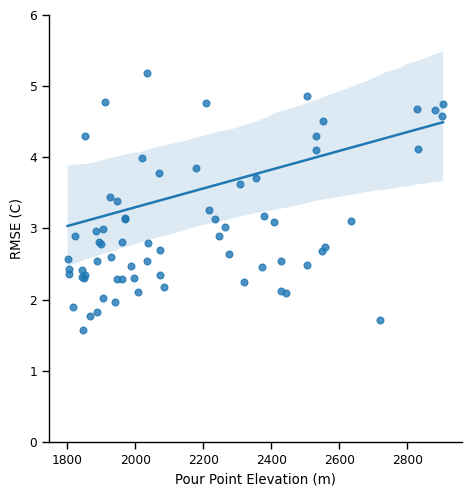

In [ ]:
ax = sns.lmplot(perf, x="elev_min", y="RMSE")
ax.set_axis_labels("Pour Point Elevation (m)", "RMSE (C)")
ax.set(ylim=(0, 6))

In [ ]:
counts = prd.groupby("id", as_index=False)["date"].count()
eligible = perf[(perf["id"].isin(counts[(counts["date"] >= 365*3)]["id"])) &
               (perf["elev_min"] >= 2400)].sort_values("NSE")
best = eligible[eligible["RMSE"] < 4].iloc[-2:]["id"]  # want to make sure it's low absolute error, too
worst = eligible.iloc[:2]["id"]
rand = eligible[-(eligible["id"].isin(pd.concat([best, worst])))].sample(n=4)["id"]
ids = [list(best), list(rand)[:2], list(rand)[2:], list(worst)]
labels = ["Best", "Random", "Random", "Worst"]

Text(0.02, 0.5, 'Daily Mean Stream Temperature (C)')

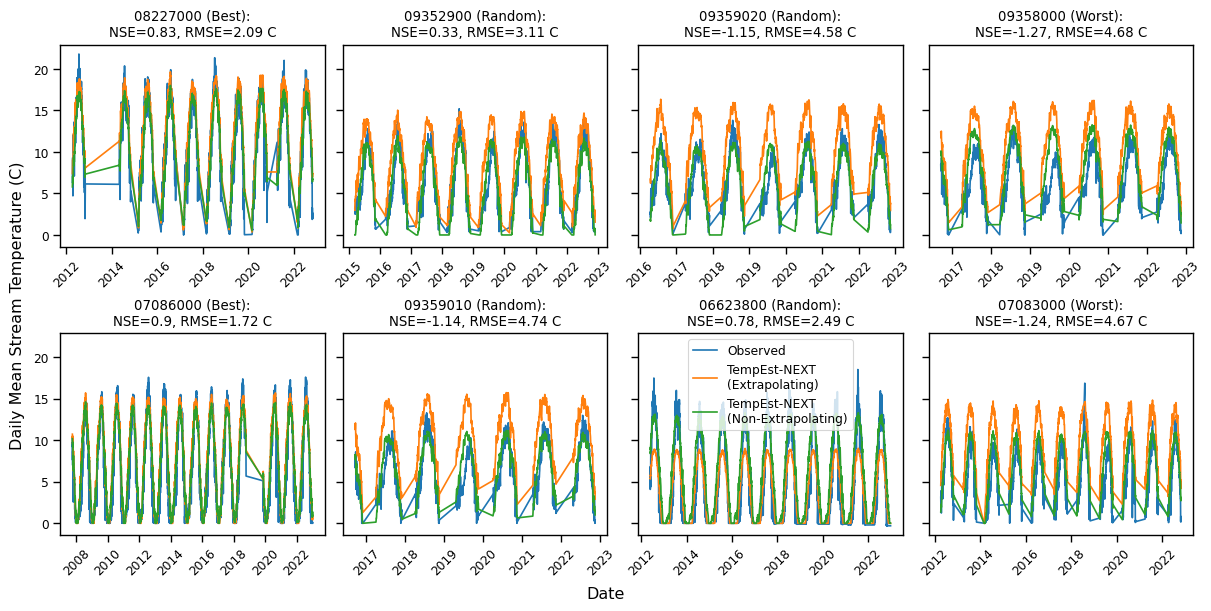

In [ ]:
# Add non-extrapolating versions.
fig, axes = plt.subplots(2, 4, figsize=(12, 6), layout="compressed", sharex=False, sharey=True)
for i in range(2):
    for j in range(4):
        ax = axes[i, j]
        which = ids[j][i]
        prow = eligible[eligible["id"] == which].iloc[0].to_dict()
        site = prd[prd["id"] == which].sort_values("date")
        site_nx = preds[preds["id"] == which].sort_values("date")
        title = f"{prow['id']} ({labels[j]}):\nNSE={round(prow['NSE'], 2)}, RMSE={round(prow['RMSE'], 2)} C"
        ax.plot(site["date"], site["temperature"], label="Observed")
        ax.plot(site["date"], site["temp.mod"], label="TempEst-NEXT\n(Extrapolating)")
        ax.plot(site_nx["date"], site_nx["temp.mod"], label="TempEst-NEXT\n(Non-Extrapolating)")
        ax.set_title(title)
        ax.tick_params(axis='x', labelrotation=45)
        if i==1 and j==2:  # hand-selected, retune as needed
            ax.legend(loc="upper center")
fig.supxlabel("Date")
fig.supylabel("Daily Mean Stream Temperature (C)")

In [ ]:
def get_ssn(day, temps):
    data = pd.DataFrame({"day": day, "temperature": temps})
    try:
        return ThreeSine.from_data(data, warn=False).to_df()
    except:
        return None  # failed fit
ssn_obs = prd.groupby("id").apply(lambda x: get_ssn(x["day"], x["temperature"]), include_groups=False)
ssn_mod = prd.groupby("id").apply(lambda x: get_ssn(x["day"], x["temp.mod"]), include_groups=False)

In [ ]:
ssn_obs.describe()

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,R2,RMSE
count,71.000000,71.000000,71.000000,71.00000,71.000000,71.000000,71.000000,71.000000,0.0,71.000000
mean,7.336799,7.496188,314.436620,65.21831,148.492958,217.084507,1.766894,1.476384,NaN,0.699586
std,3.924154,2.235039,13.675559,30.12625,11.915024,16.784982,1.062310,0.768891,NaN,0.216115
min,3.138215,0.182583,300.000000,11.00000,120.000000,200.000000,-0.457089,-0.171838,NaN,0.066742
25%,5.135121,5.961319,301.000000,29.00000,142.000000,201.000000,1.020870,0.863172,NaN,0.568907
50%,6.914991,7.374278,313.000000,80.00000,152.000000,213.000000,1.695453,1.565412,NaN,0.676151
75%,8.204409,9.005279,322.000000,88.00000,155.000000,237.000000,2.501272,1.965230,NaN,0.819809
max,30.100749,12.179893,358.000000,110.00000,176.000000,240.000000,4.765209,3.488701,NaN,1.139397


In [ ]:
ssn_mod.describe()

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,R2,RMSE
count,71.000000,71.000000,71.000000,71.000000,71.00000,71.000000,71.000000,71.000000,0.0,71.000000
mean,7.818348,7.430972,340.408451,83.323944,152.15493,209.746479,0.174838,1.033864,NaN,0.239296
std,1.810773,1.643470,23.967584,23.303908,22.82270,2.760530,0.191336,0.300289,NaN,0.078161
min,2.700813,2.753736,300.000000,27.000000,120.00000,200.000000,-0.320862,0.137153,NaN,0.123963
25%,6.780688,6.383782,321.500000,73.500000,126.50000,209.000000,0.072000,0.862215,NaN,0.184838
50%,7.950525,7.625708,349.000000,85.000000,155.00000,210.000000,0.129344,1.113621,NaN,0.221892
75%,9.448523,8.727146,364.000000,101.000000,176.00000,210.000000,0.282985,1.254011,NaN,0.274420
max,10.929135,10.672697,365.000000,110.000000,180.00000,219.000000,1.026646,1.607825,NaN,0.467514


## Walk-Forward

For walk-forward validation, we train a model on all sites up to a given year, then predict the next five year.  This is done for all prediction years from 2010-2022, allowing ten years of initial training data.  We predict five years at a time to provide sufficient coefficient estimation data, since it's running in ungaged mode.

RMSE goes up to 2.3 C again (2.2 C for 2-PC), with little penalty to R2 or bias.  So spatial and temporal extrapolation seem to have similar effects.

5-PC does worse in temporal extrapolation, with median RMSE 2.4 C. In particular, anomaly NSE is poor. But that's just because it needs more training data; RMSE drops to about 2.2 C after the first 5 years.

In [ ]:
all_data["year"] = all_data["date"].dt.year
years = list(range(2010, 2023, 5))
file = bp + f"results/WalkForward{coef_variant}.csv"
def runmod(mod, data):
    # Try/catch because some single-year snapshots don't have enough data.
    # This shouldn't happen for prediction use, but as implemented for testing,
    # missing ST obs = missing data, since the rows get dropped.
    try:
        return mod.run(data, reset=True, use_climate=False)
    except:
        return None
def runner(year):
    print(year)
    model = NEXT.NEXT.from_data(all_data[all_data["year"] < year])
    inp = all_data[(all_data["year"] >= year) & (all_data["year"] < year + 5)]
    return inp.groupby("id").apply(lambda x: runmod(model, x), include_groups=False)
if not rerun and os.path.exists(file):
    wfv = pd.read_csv(file, dtype={"id": "str"}, parse_dates=["date"])
    wfv["id"] = wfv.index
else:
    with warnings.catch_warnings(action="ignore"):
        wfv = pd.concat([runner(year) for year in years])
    wfv.to_csv(file, index_label="id")

In [ ]:
with warnings.catch_warnings(action="ignore"):
    perf = wfv.groupby("id").apply(NEWT.analysis.perf_summary)

In [ ]:
perf.describe()

,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000,1245.000000,1247.000000,1247.000000,1247.000000
mean,0.860580,2.692710,0.213863,0.976982,0.914721,-0.145274,4.031010,0.228872,2.992821
std,0.144545,1.160034,7.146252,0.018100,0.069938,1.314493,14.942076,1.571432,1.772948
min,0.000030,1.161411,-191.723885,0.824755,0.153348,-22.556496,-59.417707,-17.820769,0.270901
25%,0.843716,2.038998,0.732933,0.970384,0.901605,-0.123553,-3.345232,-0.464487,1.575994
50%,0.911560,2.412557,0.869277,0.980460,0.929638,0.221504,1.621829,0.203697,2.721331
75%,0.941924,2.959450,0.919473,0.988958,0.949889,0.405335,8.156794,0.987555,3.957834
max,0.977687,19.009865,0.974197,0.999155,1.000000,0.774747,127.232613,7.333857,15.835841


In [ ]:
with warnings.catch_warnings(action="ignore"):
    perf_byyr = wfv.groupby(["id", "year"]).apply(NEWT.analysis.perf_summary).groupby("year").median()

The first prediction years are 2010, 2015, and 2020.  These aren't distinctly low-error years, nor are the last (2014, 2019, 2022) consistently high-error.  So it doesn't seem to have any problem with extrapolating forward, in terms of RMSE.  We also don't see a trend in bias.

Text(0, 0.5, 'Median RMSE (C)')

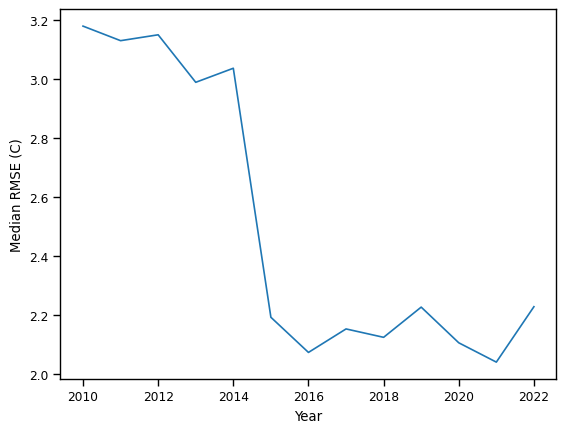

In [ ]:
ax = sns.lineplot(perf_byyr, x=perf_byyr.index, y="RMSE")
ax.set_xlabel("Year")
ax.set_ylabel("Median RMSE (C)")

Text(0, 0.5, 'Median RMSE (C)')

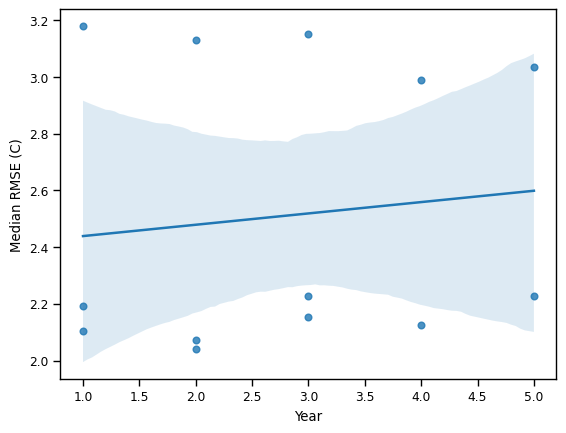

In [ ]:
perf_byyr["pyr"] = list(range(1, 6))*2 + [1,2,3]
ax = sns.regplot(perf_byyr, x="pyr", y="RMSE")
ax.set_xlabel("Year")
ax.set_ylabel("Median RMSE (C)")

In [ ]:
scipy.stats.pearsonr(perf_byyr["pyr"], perf_byyr["RMSE"])

PearsonRResult(statistic=0.11644673083120202, pvalue=0.7048045559026586)

## Regime Shift/Disturbance

# Small Stream

# True Forecast

For forecast testing, we run a 16-day forecast using HRRR and GFS (HRRR for day 1-2, GFS after that).  We also use HRRR to fill in "last week" for anomaly smoothing.  Then, we come back in a few weeks and check the performance.  Performance testing should use RMSE and bias only, since trend metrics (R2, NSE) will have minimal observed variance to work with.  Performance should be analyzed aggregated by lead time.  For the 2-day lead (tomorrow's mean), we should expect the RMSE to converge on about 2.4 C.

Since this is an ungaged model, and the only ungaged forecasting model, there is no reference performance to use for computing a skill score.  Instead, the question is whether the error is sufficiently low as to be useful.

## Shape Retrieval

As of this writing, the NLDI service is down, so we're going to use cached shapefiles.  This is (hopefully) temporary and should be changed to use regular retrieval functions.

## Run Forecast

## Verify Forecasts

In [ ]:
fcp = bp + "forecasts/"
def parse_fc(fn):
    rundate = np.datetime64(fn.split(".")[0])
    fcdat = pd.read_csv(fcp + fn, parse_dates=["date"], dtype={"id": "str"})
    fcdat = fcdat.loc[fcdat["date"] >= rundate, :]
    fcdat["rundate"] = rundate
    fcdat["lead"] = ((fcdat["date"] - rundate + np.timedelta64(1, 'D'))/np.timedelta64(1, 'D')).astype(int)  # +1: today's mean is a 1-day lead.
    return fcdat
forecast = pd.concat([parse_fc(fn) for fn in os.listdir(fcp)])
forecast = forecast.loc[forecast["lead"] < 17]  # 17-day shouldn't be in there

In [ ]:
sites = list(forecast["id"].unique())
# Run from first forecast date.
obs = nwis.get_dv(sites=sites, start="2025-02-07", end="2030-01-01", parameterCd="00010")[
    0].reset_index()[["site_no", "datetime", "00010_Mean"]].rename(
        columns={"00010_Mean": "temperature", "site_no": "id", "datetime": "date"}
    ).dropna().assign(date=lambda x: x["date"].dt.normalize().dt.tz_localize(None))
obs = obs[obs["temperature"] > -1]

In [ ]:
merged = forecast.merge(obs, on=["id", "date"], how="left").dropna()
with warnings.catch_warnings(action="ignore"):
    perf = merged.groupby(["id", "lead"]).apply(NEWT.analysis.perf_summary, include_groups=False)
perf[["RMSE", "Bias"]].describe()

,RMSE,Bias
count,3790.000000,3790.000000
mean,2.248580,-0.242173
std,0.931586,1.402694
min,0.393995,-7.413631
25%,1.573366,-0.959694
50%,2.220149,-0.313200
75%,2.786022,0.556205
max,7.741712,4.567589


In [ ]:
meds = perf.groupby("lead")[["RMSE", "Bias"]].median()
meds

,RMSE,Bias
lead,,
1,2.163856,-0.110894
2,2.229726,-0.132617
3,2.276879,-0.177071
4,2.289365,-0.229612
5,2.293067,-0.300087
6,2.247237,-0.400454
7,2.191506,-0.388728
8,2.282937,-0.371605
9,2.328784,-0.388743


In [ ]:
bylead = merged.groupby("lead").apply(NEWT.analysis.perf_summary, include_groups=False)
bylead

,,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
lead,,,,,,,,,,
1,0,0.822584,2.398115,0.817059,-0.560914,0.295973,0.779404,-1.617715,-0.139416,2.504244
2,0,0.820214,2.442033,0.813170,-0.548841,0.300300,0.779152,-2.237739,-0.195453,1.829487
3,0,0.818551,2.476688,0.810977,-0.548121,0.303722,0.779091,-2.282898,-0.201763,2.255142
4,0,0.820183,2.476627,0.812422,-0.538928,0.311417,0.779090,-2.210457,-0.197122,2.281228
5,0,0.826137,2.460249,0.817071,-0.519967,0.318401,0.781553,-2.536783,-0.229145,2.207763
6,0,0.830861,2.458983,0.819721,-0.515781,0.322277,0.783998,-3.298567,-0.303509,2.234765
7,0,0.832606,2.441743,0.821862,-0.510864,0.324703,0.784470,-3.248464,-0.302020,2.662251
8,0,0.829016,2.450914,0.819834,-0.480906,0.337115,0.780294,-2.846287,-0.266046,2.590239
9,0,0.825001,2.473021,0.816582,-0.473771,0.339762,0.777285,-2.842693,-0.268616,2.518745


In [ ]:
round(meds.reset_index().merge(bylead, on="lead", suffixes=["_median", "_global"])[["lead", "RMSE_median", "RMSE_global", "Bias_median", "Bias_global"]
                                                                                  ].rename(
    columns={"lead": "Lead Time (days)",
             "RMSE_median": "Median RMSE (C)",
             "RMSE_global": "Global RMSE (C)",
             "Bias_median": "Median Bias (C)",
             "Bias_global": "Global Bias (C)"}), 1)

,Lead Time (days),Median RMSE (C),Global RMSE (C),Median Bias (C),Global Bias (C)
0,1,2.2,2.4,-0.1,-0.1
1,2,2.2,2.4,-0.1,-0.2
2,3,2.3,2.5,-0.2,-0.2
3,4,2.3,2.5,-0.2,-0.2
4,5,2.3,2.5,-0.3,-0.2
5,6,2.2,2.5,-0.4,-0.3
6,7,2.2,2.4,-0.4,-0.3
7,8,2.3,2.5,-0.4,-0.3
8,9,2.3,2.5,-0.4,-0.3
9,10,2.3,2.5,-0.4,-0.3


In [ ]:
NEWT.analysis.perf_summary(merged)

,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
0,0.824728,2.419708,0.818507,0.867682,0.320729,0.778058,-2.760247,-0.259089,2.169594


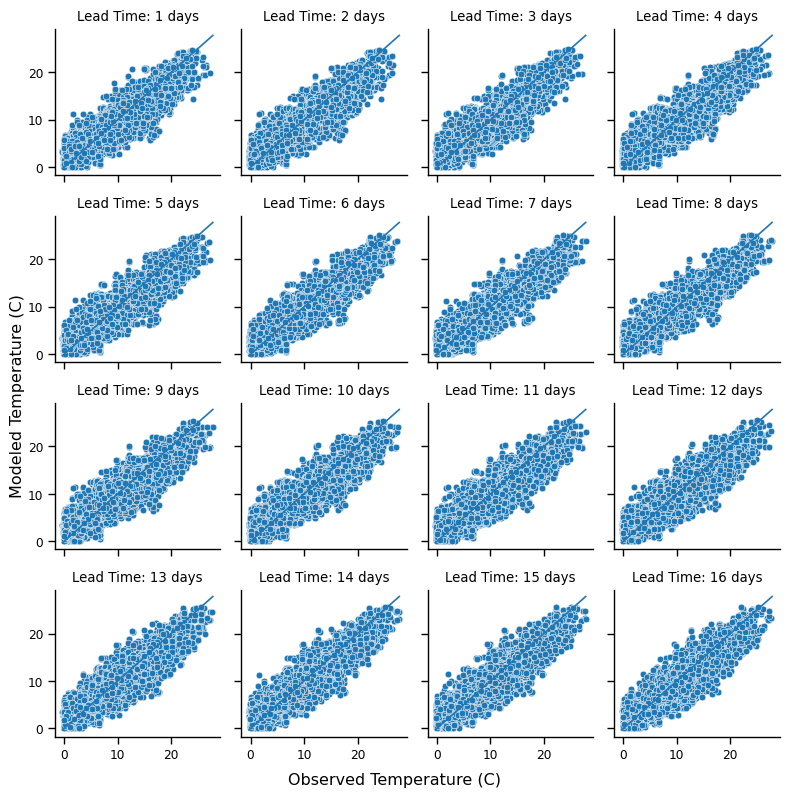

In [ ]:
# ax = merged.plot.scatter(x="temp.mod", y="temperature")
pmerged = merged.merge(bylead.round(2), on="lead", how="left")
minmax = [merged["temperature"].min(), merged["temperature"].max()]
minmax = pd.DataFrame({"x": minmax, "y": minmax})
# pmerged["lead"] = pmerged["lead"].astype(str) + " (RMSE: " + pmerged["RMSE"].astype(str) + " C)"
# fig, ax = plt.subplots(1, 1, figsize=(5, 5), layout="compressed")
# sns.scatterplot(pmerged, x="temperature", y="temp.mod", hue="lead", ax=ax)
fig = sns.relplot(pmerged, x="temperature", y="temp.mod", col="lead", col_wrap=4,
                   height=2, aspect=1, kind="scatter")
for ax in fig.axes:
    sns.lineplot(minmax, x="x", y="y", ax=ax)
fig.figure.supxlabel("Observed Temperature (C)")
fig.set_xlabels("")
fig.figure.supylabel("Modeled Temperature (C)")
fig.set_ylabels("")
fig.set_titles(col_template="Lead Time: {col_name} days")
# ax.plot(pmerged["temperature"], pmerged["temperature"], label="1:1")
# ax.set_ylabel("Modeled Temperature (C)")
# ax.set_xlabel("Observed Temperature (C)")
# ax.legend().set_title("Lead Time (days)")
plt.savefig("val_figures/forecast.png", dpi=1000)

## National Plots

In [ ]:
states = gpd.read_file("usa_states/cb_2018_us_state_20m.shp")
states = states[-states["STUSPS"].isin(["AK", "HI", "PR"])]

In [ ]:
coords = test_data_hrrr.groupby("id")[["lat", "lon"]].agg("first")
bestworst = (perf.groupby("id").
             apply(lambda x: pd.DataFrame({"best": x["RMSE"].min(), "worst": x["RMSE"].max()}, index=[0]),
                   include_groups=False).
             merge(coords, on="id", how="left"))

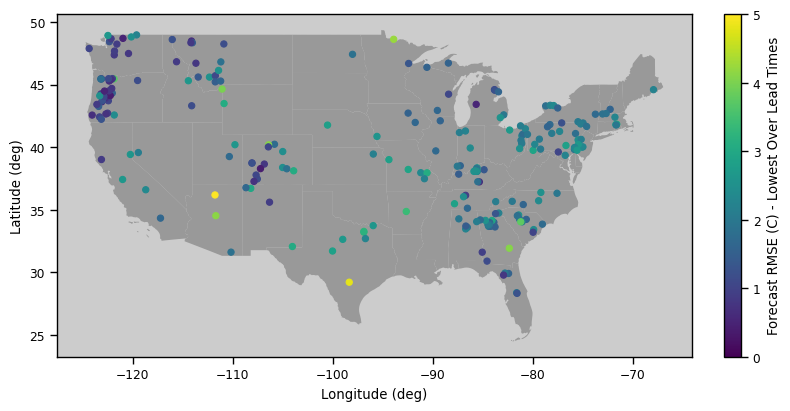

In [ ]:
fig = plt.figure(figsize=(8, 4), layout="compressed")
ax = plt.axes(facecolor="#CCC")
states.plot(ax=ax, color="#999")
bestworst.plot.scatter(x="lon", y="lat", c="best", ax=ax, colormap="viridis", vmin=0, vmax=5)
cb = ax.collections[1].colorbar
cb.set_label("Forecast RMSE (C) - Lowest Over Lead Times")
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Latitude (deg)")
plt.savefig("val_figures/conus_forecast_best.png", dpi=1000)

In [ ]:
bestworst.describe()

,best,worst,lat,lon
count,238.000000,238.000000,238.000000,238.000000
mean,1.886758,2.564691,39.969494,-95.952928
std,0.849601,0.978901,4.883421,17.358761
min,0.393995,0.568587,28.332787,-124.357089
25%,1.248961,1.900461,35.815005,-111.770735
50%,1.849987,2.571227,40.206381,-87.479876
75%,2.348852,3.080046,43.700886,-81.556067
max,6.790202,7.741712,48.984601,-67.935278


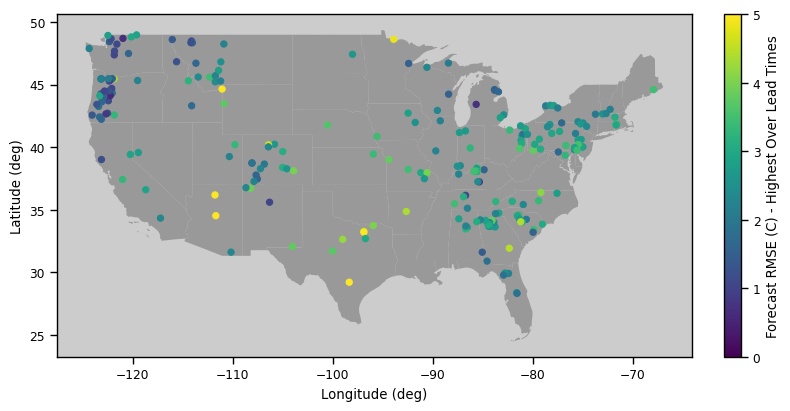

In [ ]:
fig = plt.figure(figsize=(8, 4), layout="compressed")
ax = plt.axes(facecolor="#CCC")
states.plot(ax=ax, color="#999")
bestworst.plot.scatter(x="lon", y="lat", c="worst", ax=ax, colormap="viridis", vmin=0, vmax=5)
cb = ax.collections[1].colorbar
cb.set_label("Forecast RMSE (C) - Highest Over Lead Times")
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Latitude (deg)")
plt.savefig("val_figures/conus_forecast_worst.png", dpi=1000)

# Error Correlations

In [ ]:
preds = pd.read_csv(bp + f"results/TestSet_hindcast{coef_variant}.csv", dtype={"id": "str"}, parse_dates=["date"])
kfr = pd.read_csv(bp + f"results/kfold_pca{coef_variant}.csv", dtype={"id": "str"}, parse_dates=["date"])
gcols = ["id", "elev_min", "elev", "lat", "lon", "area", 'water', 'developed', 'barren', 'forest', 'shrubland', 'herbaceous',
       'cultivated', 'wetland', 'ice_snow', "slope", "flowdir"]
ycols = ["date", "temp.mod", "temperature"]
cols = gcols + ycols
preds = pd.concat([preds[cols], kfr[cols]])

In [ ]:
x = np.arange(10)
y = np.arange(10, 0, -1)
x[x<y] = y[x<y]
x

array([10,  9,  8,  7,  6,  5,  6,  7,  8,  9])

In [ ]:
with warnings.catch_warnings(action="ignore"):
    perf = preds.groupby(gcols).apply(NEWT.analysis.perf_summary, include_groups=False).reset_index()

In [ ]:
hap = perf[perf["area"] > 3e10]

Look list (R>0.1 across pbias, R2, or NSE):

- Water: effects negligible, it's noise because of few sites >5%.
- Slope: there is definitely some performance penalty to steep watersheds, but minimal.
- Latitude: is just because the warm Southeastern sites do well.
- Shrubland: definitely correlates with bias, but weakly (R2 0.01).
- Longitude: Western sites have a bit worse R2, which isn't news.
- Forest: does correlate with some penalty to R2 (R2 0.04, p~0).
- Cultivated: just noise from the few sites >20%.
- Developed: same.
- Barren: there's a real penalty to R2, but weak.
- Wetland: nothing there.

In [ ]:
sel = perf#[perf["area"] > 3e10]
ax = sns.regplot(sel, x="area", y="RMSE")
# ax.set_xlim(4e10, 10e10)
# ax.set_ylim(0, 1)

In [ ]:
scipy.stats.pearsonr(sel["area"], sel["Pbias"])

PearsonRResult(statistic=-0.1014342840394578, pvalue=0.45695743903583164)

In [ ]:
perf[gcols[1:]].agg(lambda x: scipy.stats.pearsonr(x, perf["NSE"]).statistic).abs().sort_values(ascending=False)

water         0.094325
elev_min      0.089143
lon           0.078524
elev          0.071103
barren        0.068757
forest        0.049966
developed     0.043598
cultivated    0.043091
shrubland     0.038611
wetland       0.038084
area          0.025986
herbaceous    0.021701
slope         0.011757
lat           0.005863
ice_snow      0.003664
flowdir       0.002542
dtype: float64

# Misc Plots

In [ ]:
preds = pd.read_csv(bp + f"results/TestSet_hindcast{coef_variant}.csv", dtype={"id": "str"}, parse_dates=["date"])
# kfr = pd.read_csv(bp + f"results/kfold_pca{coef_variant}.csv", dtype={"id": "str"}, parse_dates=["date"])
cols = ["id", "date", "temp.mod", "temperature"]
# preds = pd.concat([preds[cols], kfr[cols]])
# preds = pd.read_csv(bp + "TE2Xval.csv", dtype={"id": "str"}, parse_dates=["date"])[cols]
# preds = preds.loc[preds["temperature"] < 35, :]  # for direct comparison to USGS dataset
perf = preds.groupby("id").apply(NEWT.analysis.perf_summary, include_groups=False)

## 1:1 Plot with Stats

## Sitewise R2 CDF

## Temperature Density

## Sim/Obs Sample

In [ ]:
counts = preds.groupby("id", as_index=False)["date"].count()
eligible = perf.reset_index()[perf.unstack().index.isin(counts[(counts["date"] >= 365*3)]["id"])].sort_values("R2")
best = eligible[eligible["RMSE"] < 1.8].iloc[-2:]["id"]  # want to make sure it's low absolute error, too
worst = eligible.iloc[:2]["id"]
rand = eligible[-(eligible["id"].isin(pd.concat([best, worst])))].sample(n=4)["id"]
ids = [list(best), list(rand)[:2], list(rand)[2:], list(worst)]
labels = ["Best", "Random", "Random", "Worst"]

In [ ]:
eligible.iloc[0].to_dict()

{'id': '02334430',
 'level_1': 0,
 'R2': 0.043902839603288564,
 'RMSE': 7.763608807462353,
 'NSE': -24.188984623956227,
 'StationaryNSE': 0.9788396728160809,
 'ClimatologyNSE': 0.6440955568663603,
 'AnomalyNSE': -2.4866062759437173,
 'Pbias': 52.56739555945759,
 'Bias': 5.702965883107109,
 'MaxMiss': 11.135823133684339}

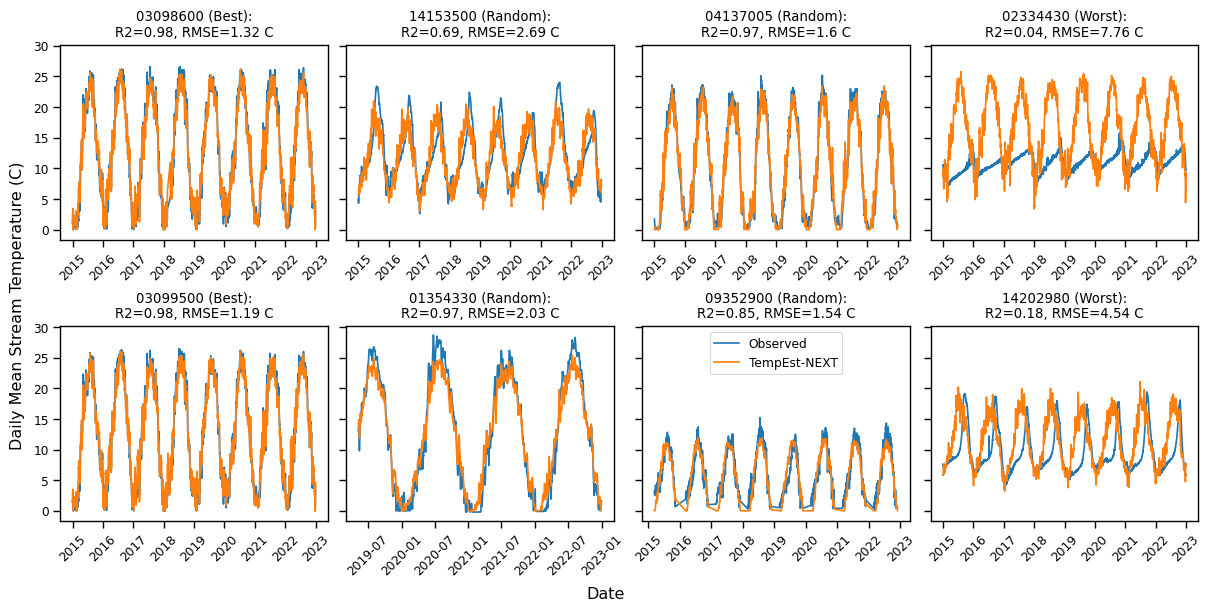

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), layout="compressed", sharex=False, sharey=True)
for i in range(2):
    for j in range(4):
        ax = axes[i, j]
        which = ids[j][i]
        prow = eligible[eligible["id"] == which].iloc[0].to_dict()
        site = preds[preds["id"] == which].sort_values("date")
        title = f"{prow['id']} ({labels[j]}):\nR2={round(prow['R2'], 2)}, RMSE={round(prow['RMSE'], 2)} C"
        ax.plot(site["date"], site["temperature"], label="Observed")
        ax.plot(site["date"], site["temp.mod"], label="TempEst-NEXT")
        ax.set_title(title)
        ax.tick_params(axis='x', labelrotation=45)
        if i==1 and j==2:  # hand-selected, retune as needed
            ax.legend(loc="upper center")
fig.supxlabel("Date")
fig.supylabel("Daily Mean Stream Temperature (C)")
plt.savefig("val_figures/comparison_sample.png", dpi=1000)